## Cleaning, EDA, Preprocessing

In this notebook, our goal will be to clean, get insights,and prepare our data for modeling with the datasets provided as per below:

1. Load in datasets
2. Data cleaning: Initial check
3. EDA
4. Feature engineering
5. Prep Test set
5. Export data for modeling stage



## Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings

from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Importing Datasets (all)
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
weather = pd.read_csv('../assets/weather.csv')
spray = pd.read_csv('../assets/spray.csv')

In [3]:
# # show all rows and columns
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Defined Functions

In [4]:
def eda(dataframe):
    """Runs basic EDA on dataframe."""
    print("dataframe shape \n", dataframe.shape, '\n')
    print("dataframe types \n", dataframe.dtypes, '\n')
    print("dataframe describe \n", dataframe.describe(), '\n')
    print("dataframe describe \n", dataframe.describe(exclude=np.number).T, '\n')
    print("missing values \n", dataframe.isnull().sum(), '\n')
    print("duplicate values \n", dataframe.duplicated().sum(), '\n')
    print("dataframe columns \n", dataframe.columns, '\n')
    
    #check if column is unique
    for i in dataframe.columns:
        print('{} is unique: {}'.format(i, dataframe[i].is_unique))

In [5]:
def split_date (data):
    """split into year and month"""
    data['year'] = data.date.dt.year
    data['month'] = data.date.dt.month
    return

In [6]:
def replace_val(df, column, old_value, new_value):
    """ for replacing values in columns"""
    df[column] = df[column].replace({old_value: new_value})

In [7]:
def replace_median(df, column):
    """ replace NaN values with median"""
    df[column].fillna((df[column].median()), inplace=True)

In [8]:
def humidity_calc(row):
    """calculate humidity"""
    wetC = (row['wetbulb_avg'] - 32) / 1.8
    dryC = (row['temp_avg'] - 32) / 1.8

    N = 0.6687451584
    e_d = 6.112 * np.exp((17.502 * dryC) / (240.97 + dryC))
    e_w = 6.112 * np.exp((17.502 * wetC) / (240.97 + wetC))
    rh = 100 * (e_w - N*(1 + 0.00115 * wetC) * (dryC - wetC)) / e_d 
    
    return np.round(rh, decimals = 0)

In [9]:
def apply_change_df (data):
    """ prepping test set"""
    # Rename Column to snake_case
    data.columns = map(str.lower, data.columns)
    
    ##1.5 to delete
    # Changes date to datetime formats and split
    data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
    split_date(data)
    
    # Merge data with feature engineered weather dataset
    data = pd.merge(data, weather, how='left', on=['date','month','year'])
    
    # Get dummies for categorical variable
    data = pd.get_dummies(data, columns = ['species'])
    data = pd.get_dummies(data, columns = ['trap'])
    
    # Get dummies for month and year variable
    data = pd.get_dummies(data, columns = ['month'])
    data = pd.get_dummies(data, columns = ['year'])
    
#     # Drop columns that are address related
#     data.drop(['address',
#                 'block',
#                 'street',
#                 'addressnumberstreet',
#                 'address_accuracy'], axis=1, inplace=True)
    
    print(f"dataset shape: {data.shape}")
    
    return

***

# Cleaning

We are presented with 4 datasets:

1. train.csv
2. test.csv
3. weather.csv
4. spray.csv


### Train Dataset 

In [10]:
# view dataset
train.head()

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [11]:
# view EDA
eda(train)

dataframe shape 
 (10506, 12) 

dataframe types 
 Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object 

dataframe describe 
               Block      Latitude     Longitude  AddressAccuracy  \
count  10506.000000  10506.000000  10506.000000     10506.000000   
mean      35.687797     41.841139    -87.699908         7.819532   
std       24.339468      0.112742      0.096514         1.452921   
min       10.000000     41.644612    -87.930995         3.000000   
25%       12.000000     41.732984    -87.760070         8.000000   
50%       33.000000     41.846283    -87.694991         8.000000   
75%       52.000000     41.95

In [12]:
print(train['Date'].min())
print(train['Date'].max())

2007-05-29
2013-09-26


In [13]:
train[train.duplicated()].head()

# duplicates are traps with excess of 50 mosquitoes, to be processed later

Date                                            Address  \
99   2007-06-26     2200 West 113th Street, Chicago, IL 60643, USA   
295  2007-07-11     2200 West 113th Street, Chicago, IL 60643, USA   
351  2007-07-11     3500 West 116th Street, Chicago, IL 60655, USA   
353  2007-07-11     3500 West 116th Street, Chicago, IL 60655, USA   
512  2007-07-18  3300 West Randolph Street, Chicago, IL 60612, USA   

                    Species  Block          Street  Trap  \
99   CULEX PIPIENS/RESTUANS     22      W 113TH ST  T086   
295  CULEX PIPIENS/RESTUANS     22      W 113TH ST  T086   
351  CULEX PIPIENS/RESTUANS     35      W 116TH ST  T158   
353  CULEX PIPIENS/RESTUANS     35      W 116TH ST  T158   
512          CULEX RESTUANS     33   E RANDOLPH ST  T044   

               AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
99      2200  W 113TH ST, Chicago, IL  41.688324 -87.676709                8   
295     2200  W 113TH ST, Chicago, IL  41.688324 -87.676709                8   
351     3500  W 116TH ST, Chicago, IL  41.682587 -87.707973                9   
353     3500  W 116TH ST, Chicago, IL  41.682587 -87.707973                9   
512  3300  E RANDOLPH ST, Chicago, IL  41.883284 -87.705085                8   

     NumMosquitos  WnvPresent  
99              1           0  
295            50           0  
351            50           0  
353            50           0  
512             1           0



<div class="alert alert-block alert-info">
    
<b>Train Dataset:</b>
    
- 12 columns, 10506 rows
- extra columns: 'NumMosquitos' and 'WnvPresent'
- no nulls
- 813 duplicates
- Date needs to be changed to datetime format
- data ranges from 2007-05-29 to 2013-09-26
    

</div>

***

### Test Dataset 

In [14]:
# view dataset
test.head()

Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3   4  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4   5  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

In [15]:
# view EDA
eda(test)

dataframe shape 
 (116293, 11) 

dataframe types 
 Id                          int64
Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
dtype: object 

dataframe describe 
                   Id          Block       Latitude      Longitude  \
count  116293.000000  116293.000000  116293.000000  116293.000000   
mean    58147.000000      41.131100      41.849389     -87.693658   
std     33571.041765      24.864726       0.106593       0.080699   
min         1.000000      10.000000      41.644612     -87.930995   
25%     29074.000000      18.000000      41.753411     -87.750938   
50%     58147.000000      39.000000      41.862292     -87.694991   
75%     87220.000000      61.000000      41.951866     

In [16]:
# view date range
print(train['Date'].min())
print(train['Date'].max())

2007-05-29
2013-09-26


***



<div class="alert alert-block alert-info">
    
    
<b>Test Dataset:</b> 
    
- 11 columns, 116293 rows 
- extra columns: 'Id'
- no nulls
- no duplicates
- Date needs to be changed to datetime format
- data ranges from 2007-05-29 to 2013-09-26

    
<b>Initial thoughts:</b> 
There are no mosquito number infomation in our test set so our predictions have to be based on weather, location, time, and spraying. We might need to do predict the amount of mosquitoes in order to predict the amount of WNV?

Train duplicates might be cause by mosquitoes in trap exceeding 50 counts, this will need to be processed later. 
Train and test data ranges in the same period
    
</div>



***

### Weather Dataset 


In [17]:
# view dataset
weather.head()

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [18]:
# view EDA
eda(weather)

dataframe shape 
 (2944, 22) 

dataframe types 
 Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object 

dataframe describe 
            Station         Tmax         Tmin     DewPoint  ResultSpeed  \
count  2944.000000  2944.000000  2944.000000  2944.000000  2944.000000   
mean      1.500000    76.166101    57.810462    53.457880     6.960666   
std       0.500085    11.461970    10.381939    10.675181     3.587527   
min       1.000000    41.000000    29.000000    22.000000     0.100000   
25%       1.000000    69.000000    50.

In [19]:
# checking for columns containing M or T as missing values

check_col = ['Tavg', 'Depart','WetBulb','Heat','Cool',
             'Sunrise','Sunset','Depth','Water1','SnowFall',
            'PrecipTotal','StnPressure','SeaLevel','AvgSpeed']

print(weather.shape)
print('')

for col in weather[check_col]:
    station_1 = len(weather[(weather[col].str.contains('\D')) & (weather['Station']==1)])
    print(f"{col}(station 1): {str(station_1)} missing values")
    
    station_2 = len(weather[(weather[col].str.contains('\D')) & (weather['Station']==2)])
    print(f"{col}(station 2): {str(station_2)} missing values")
    print('**************')

(2944, 22)

Tavg(station 1): 0 missing values
Tavg(station 2): 11 missing values
**************
Depart(station 1): 1271 missing values
Depart(station 2): 1472 missing values
**************
WetBulb(station 1): 3 missing values
WetBulb(station 2): 1 missing values
**************
Heat(station 1): 0 missing values
Heat(station 2): 11 missing values
**************
Cool(station 1): 1096 missing values
Cool(station 2): 1021 missing values
**************
Sunrise(station 1): 0 missing values
Sunrise(station 2): 1472 missing values
**************
Sunset(station 1): 0 missing values
Sunset(station 2): 1472 missing values
**************
Depth(station 1): 0 missing values
Depth(station 2): 1472 missing values
**************
Water1(station 1): 1472 missing values
Water1(station 2): 1472 missing values
**************
SnowFall(station 1): 1472 missing values
SnowFall(station 2): 1472 missing values
**************
PrecipTotal(station 1): 1472 missing values
PrecipTotal(station 2): 1472 missing values
*

In [20]:
# dropping unwanted columns
droplist = ['Depart', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth',
       'Water1', 'SnowFall', 'CodeSum']
weather.drop(droplist, axis = 1, inplace= True)

In [21]:
# replace M to NaN
weather = weather.replace('M', np.nan)
weather = weather.replace('-', np.nan)

# imputing Trace value to < 0.1
replace_val(weather, 'PrecipTotal', '  T' , 0.005)

# Tavg to be for average of Tmax and Tmin
weather['Tavg'] = round((weather['Tmax'] + weather['Tmin'])/2+0.1)

In [22]:
# change column types
weather['Tavg'] = weather['Tavg'].astype(float)
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)
weather['StnPressure'] = weather['StnPressure'].astype(float)
weather['SeaLevel'] = weather['SeaLevel'].astype(float)
weather['AvgSpeed'] = weather['AvgSpeed'].astype(float)
weather['WetBulb'] = weather['WetBulb'].astype(float)

In [23]:
# view dataset
weather.head()

Station        Date  Tmax  Tmin  Tavg  DewPoint  WetBulb  PrecipTotal  \
0        1  2007-05-01    83    50  67.0        51     56.0          0.0   
1        2  2007-05-01    84    52  68.0        51     57.0          0.0   
2        1  2007-05-02    59    42  51.0        42     47.0          0.0   
3        2  2007-05-02    60    43  52.0        42     47.0          0.0   
4        1  2007-05-03    66    46  56.0        40     48.0          0.0   

   StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
0        29.10     29.82          1.7         27       9.2  
1        29.18     29.82          2.7         25       9.6  
2        29.38     30.09         13.0          4      13.4  
3        29.44     30.08         13.3          2      13.4  
4        29.39     30.12         11.7          7      11.9

In [24]:
# replacing nan with median

replace_median(weather, 'PrecipTotal')
replace_median(weather, 'StnPressure')
replace_median(weather, 'SeaLevel')
replace_median(weather, 'AvgSpeed')
replace_median(weather, 'WetBulb')

In [25]:
#check null values
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [26]:
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]

# add long, lat
weather_stn1 ['Latitude'] = 41.995
weather_stn1 ['Longitude'] = -87.933
weather_stn2 ['Latitude'] = 41.786
weather_stn2 ['Longitude'] = -87.752

# drop station column
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)

#join df
weather = weather_stn1.merge(weather_stn2, on='Date')

#change column names
weather.columns = ['Date', 'Tmax_1', 'Tmin_1', 'Tavg_1', 'DewPoint_1', 'WetBulb_1',
       'PrecipTotal_1', 'StnPressure_1', 'SeaLevel_1',
       'ResultSpeed_1', 'ResultDir_1', 'AvgSpeed_1', 'Latitude_1',
       'Longitude_1', 'Tmax_2', 'Tmin_2', 'Tavg_2', 'DewPoint_2', 'WetBulb_2',
       'PrecipTotal_2', 'StnPressure_2', 'SeaLevel_2',
       'ResultSpeed_2', 'ResultDir_2', 'AvgSpeed_2', 'Latitude_2',
       'Longitude_2']


In [27]:
# view dataset
weather.head()

Date  Tmax_1  Tmin_1  Tavg_1  DewPoint_1  WetBulb_1  PrecipTotal_1  \
0  2007-05-01      83      50    67.0          51       56.0          0.000   
1  2007-05-02      59      42    51.0          42       47.0          0.000   
2  2007-05-03      66      46    56.0          40       48.0          0.000   
3  2007-05-04      66      49    58.0          41       50.0          0.005   
4  2007-05-05      66      53    60.0          38       49.0          0.005   

   StnPressure_1  SeaLevel_1  ResultSpeed_1  ...  DewPoint_2  WetBulb_2  \
0          29.10       29.82            1.7  ...          51       57.0   
1          29.38       30.09           13.0  ...          42       47.0   
2          29.39       30.12           11.7  ...          40       50.0   
3          29.31       30.05           10.4  ...          42       50.0   
4          29.40       30.10           11.7  ...          39       50.0   

   PrecipTotal_2  StnPressure_2  SeaLevel_2  ResultSpeed_2  ResultDir_2  \
0          0.000          29.18       29.82            2.7           25   
1          0.000          29.44       30.08           13.3            2   
2          0.000          29.46       30.12           12.9            6   
3          0.000          29.36       30.04           10.1            7   
4          0.005          29.46       30.09           11.2            7   

   AvgSpeed_2  Latitude_2  Longitude_2  
0         9.6      41.786      -87.752  
1        13.4      41.786      -87.752  
2        13.2      41.786      -87.752  
3        10.4      41.786      -87.752  
4        11.5      41.786      -87.752  

[5 rows x 27 columns]

In [28]:
# view date range
print(weather['Date'].min())
print(weather['Date'].max())

2007-05-01
2014-10-31


<div class="alert alert-block alert-info">

<b>Weather Dataset:</b><br>
- 22 columns, 2944 rows
- no null values
- no duplicate values
- date range : 2007-05-01 to 2014-10-31
- Dataset is riddled with "M" for missing, "T" for trace data, "-" for some data from station 2.

<br>
    
><u>Columns Dropped:</u>  
>1. Depart - difference from 30 year avg
>2. Heat - avg temp degrees above 65 F - can be calculated
>3. Cool - avg temp degrees below 65 F  - can be calculated
>4. Sunrise - calculated sunrise - not needed
>5. Sunset - calculated sunset - not needed
>6. Depth - 0 or Missing
>7. Water1 - all Missing
>8. SnowFall - Missing or 0, only 1 value of 0.01
>9. CodeSum - too little inputs to be meaningful 

><u>Imputation and Additional Columns:</u>
>1. Tavg: M = round up((tmax + tmin)/2) **
>2. PrecipTotal: T = 0.005
>3. PrecipTotal M = median
>4. StnPressure M = median
>5. SeaLevel M = median
>6. AvgSpeed M = median
>7. added 'Latitude' column
>8. added 'Longitude' column
    
</div>

***

### Spray Dataset

In [29]:
# view dataset
spray.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [30]:
#view EDA
eda(spray)

dataframe shape 
 (14835, 4) 

dataframe types 
 Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object 

dataframe describe 
            Latitude     Longitude
count  14835.000000  14835.000000
mean      41.904828    -87.736690
std        0.104381      0.067292
min       41.713925    -88.096468
25%       41.785001    -87.794225
50%       41.940075    -87.727853
75%       41.980978    -87.694108
max       42.395983    -87.586727 

dataframe describe 
       count unique         top  freq
Date  14835     10  2013-08-15  2668
Time  14251   8583  7:44:32 PM   541 

missing values 
 Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64 

duplicate values 
 541 

dataframe columns 
 Index(['Date', 'Time', 'Latitude', 'Longitude'], dtype='object') 

Date is unique: False
Time is unique: False
Latitude is unique: False
Longitude is unique: False


In [31]:
# changes time to datetime format
spray['Time'] = pd.to_datetime(spray['Time'], infer_datetime_format=True)

# changes time to the hour of the day
spray['Time'] = spray['Time'].dt.hour

In [32]:
# view duplicates
spray[spray.duplicated()].head(10)

Date  Time   Latitude  Longitude
485  2011-09-07  19.0  41.983917 -87.793088
490  2011-09-07  19.0  41.986460 -87.794225
491  2011-09-07  19.0  41.986460 -87.794225
492  2011-09-07  19.0  41.986460 -87.794225
493  2011-09-07  19.0  41.986460 -87.794225
494  2011-09-07  19.0  41.986460 -87.794225
495  2011-09-07  19.0  41.986460 -87.794225
496  2011-09-07  19.0  41.986460 -87.794225
497  2011-09-07  19.0  41.986460 -87.794225
498  2011-09-07  19.0  41.986460 -87.794225

In [33]:
# seems like real duplicates, will drop these
spray.drop_duplicates(inplace=True)

In [34]:
# view dates of spray
spray['Date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2013-07-25    1607
2013-08-22    1587
2011-09-07    1573
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

In [35]:
# view date range
print(spray['Date'].min())
print(spray['Date'].max())

2011-08-29
2013-09-05


In [36]:
# check null values
spray[spray.isnull()].tail()

Date  Time  Latitude  Longitude
14830  NaN   NaN       NaN        NaN
14831  NaN   NaN       NaN        NaN
14832  NaN   NaN       NaN        NaN
14833  NaN   NaN       NaN        NaN
14834  NaN   NaN       NaN        NaN

In [37]:
# view dataset
spray.head()

Date  Time   Latitude  Longitude
0  2011-08-29  18.0  42.391623 -88.089163
1  2011-08-29  18.0  42.391348 -88.089163
2  2011-08-29  18.0  42.391022 -88.089157
3  2011-08-29  18.0  42.390637 -88.089158
4  2011-08-29  18.0  42.390410 -88.088858

<div class="alert alert-block alert-info">

<b>Spray Dataset:</b>
- 4 columns, 14835 rows
- 541 duplicated values dropped
- 584 null rows dropped
- 'Time' changed to reflect hour in the day instead
- date range : 2011-08-29 to 2013-09-05
- unique date counts : 10 (i.e 10 spray dates in date range)

</div>

***

### Clean up formats

In [38]:
# Map the lowering function to all column names
train.columns = map(str.lower, train.columns)
# test.columns = map(str.lower, test.columns)
weather.columns = map(str.lower, weather.columns)
spray.columns = map(str.lower, spray.columns)

In [39]:
# changes date to datetime formats
train['date'] = pd.to_datetime(train['date'], infer_datetime_format=True)
weather['date'] = pd.to_datetime(weather['date'], infer_datetime_format=True)
spray['date'] = pd.to_datetime(spray['date'], infer_datetime_format=True)

In [40]:
#Save cleaned dataframe to csv
train.to_csv('../assets/train_cleaned.csv', index=False)
weather.to_csv('../assets/weather_cleaned.csv', index=False)
spray.to_csv('../assets/spray_cleaned.csv', index=False)

***

# EDA and Feature Engineering

## Train set

In [41]:
# imbalanced data
train.wnvpresent.value_counts()

0    9955
1     551
Name: wnvpresent, dtype: int64

In [42]:
# imbalanced data
train.wnvpresent.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

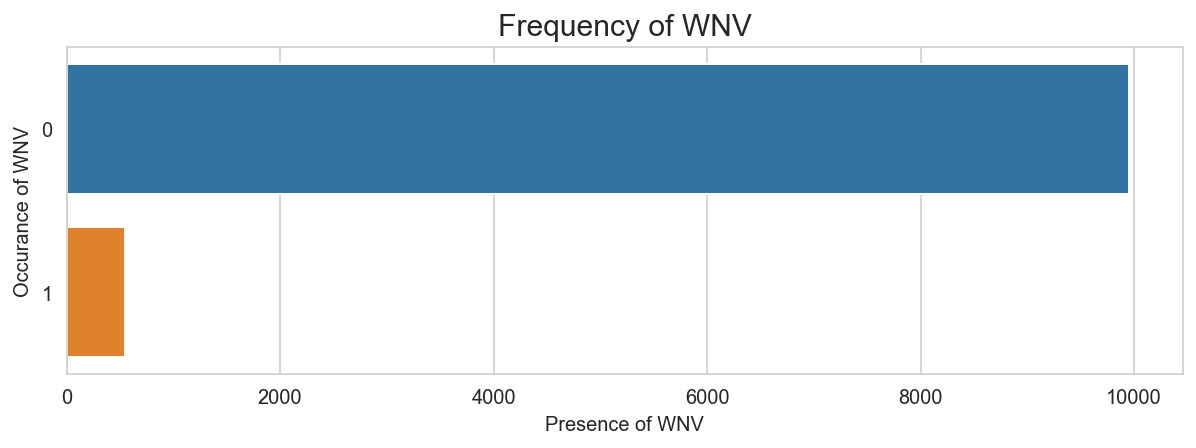

In [43]:
# plot imbalanced data
plt.figure(figsize=(10,3))
sns.countplot(y="wnvpresent", data=train)
plt.title('Frequency of WNV', fontsize=15)
plt.xlabel('Presence of WNV')
plt.ylabel('Occurance of WNV');

<div class="alert alert-block alert-info">
<b>Observation:</b> 

- Our Dataset is quite imbalanced with 5.24% being positive targets
</div>

In [44]:
# view percentage of mosquitoes caught by species
train['species'].value_counts(normalize = True)

CULEX PIPIENS/RESTUANS    0.452313
CULEX RESTUANS            0.260803
CULEX PIPIENS             0.256901
CULEX TERRITANS           0.021131
CULEX SALINARIUS          0.008186
CULEX TARSALIS            0.000571
CULEX ERRATICUS           0.000095
Name: species, dtype: float64

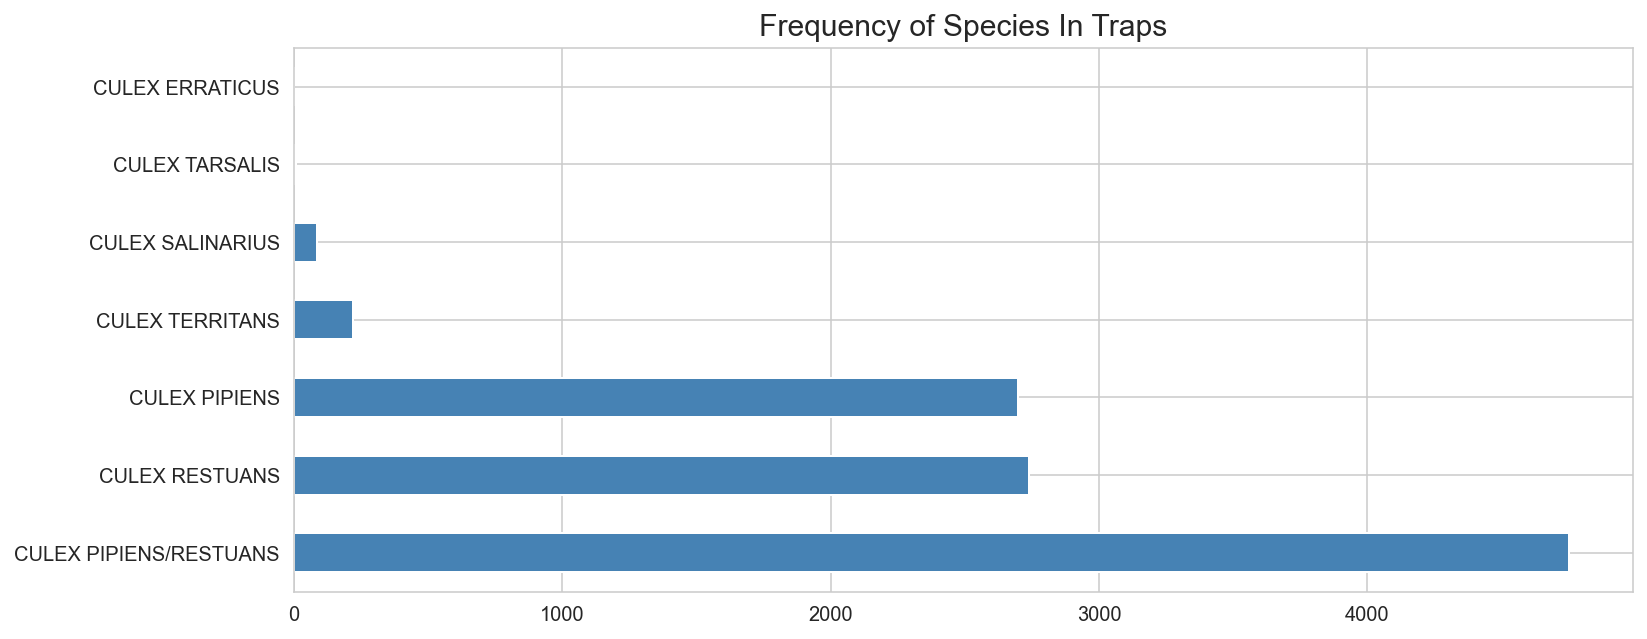

In [45]:
# plot mosquitoes caught by species
train['species'].value_counts().plot(kind = 'barh', figsize=(12,5), color='steelblue')
plt.title('Frequency of Species In Traps', fontsize=15);

In [46]:
# species and WNV count df
species_wnv = pd.DataFrame(train['species'].value_counts()).reset_index()

species_wnv = pd.merge(species_wnv, pd.DataFrame(train[train['wnvpresent']==1]['species'].value_counts()).reset_index(), how='left', on='index')

species_wnv.columns = ['species', 'num_observations', 'obs_w_wnv']

In [47]:
# view new df with Species and WNV observations
species_wnv

species  num_observations  obs_w_wnv
0  CULEX PIPIENS/RESTUANS              4752      262.0
1          CULEX RESTUANS              2740       49.0
2           CULEX PIPIENS              2699      240.0
3         CULEX TERRITANS               222        NaN
4        CULEX SALINARIUS                86        NaN
5          CULEX TARSALIS                 6        NaN
6         CULEX ERRATICUS                 1        NaN

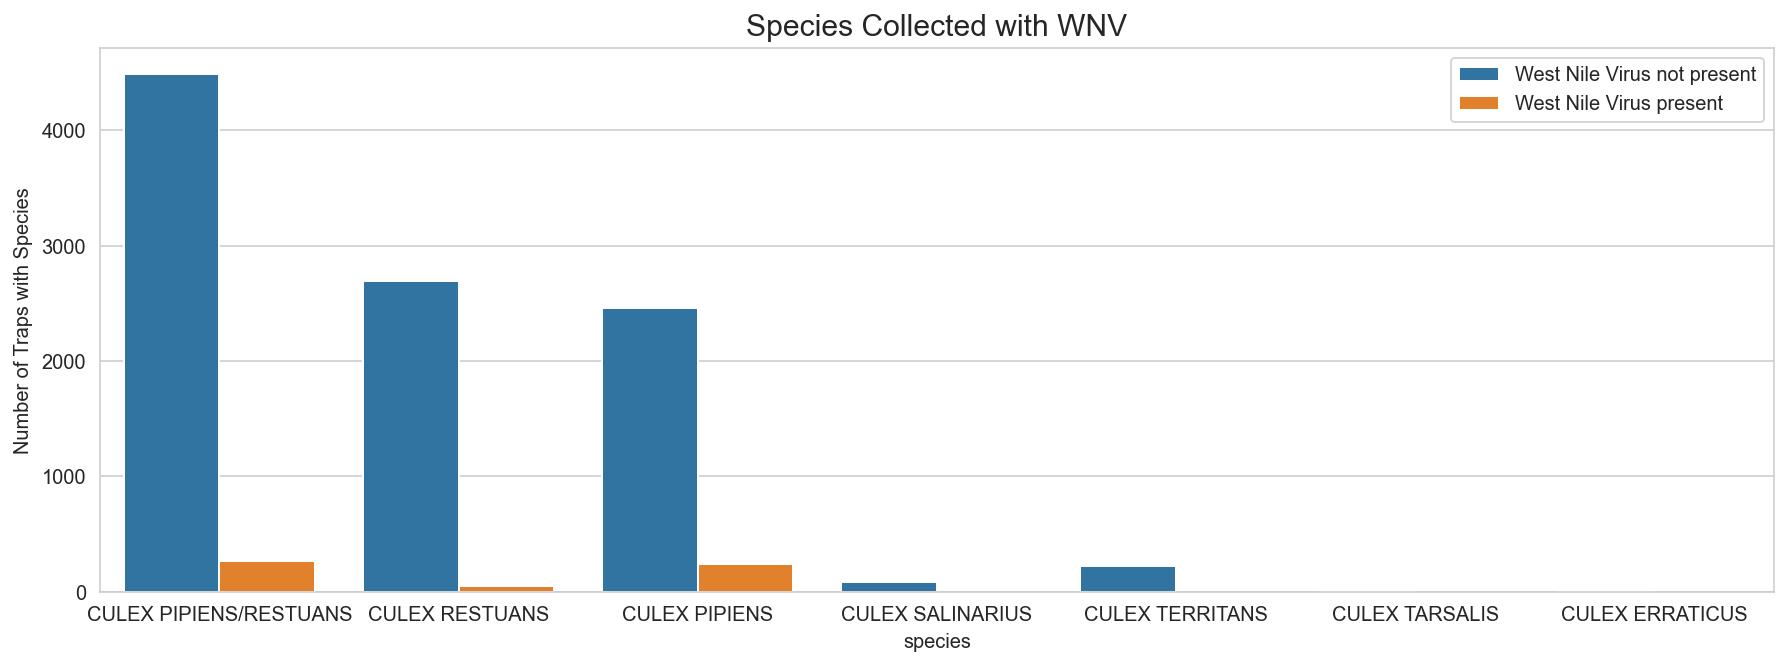

In [48]:
# WNV presence by species
plt.figure(figsize=(15,5))
sns.countplot(x='species', hue='wnvpresent', data=train)
plt.xticks(rotation=0)
plt.legend(['West Nile Virus not present', 'West Nile Virus present'], loc=1)
plt.ylabel('Number of Traps with Species')
plt.title('Species Collected with WNV', fontsize=15);

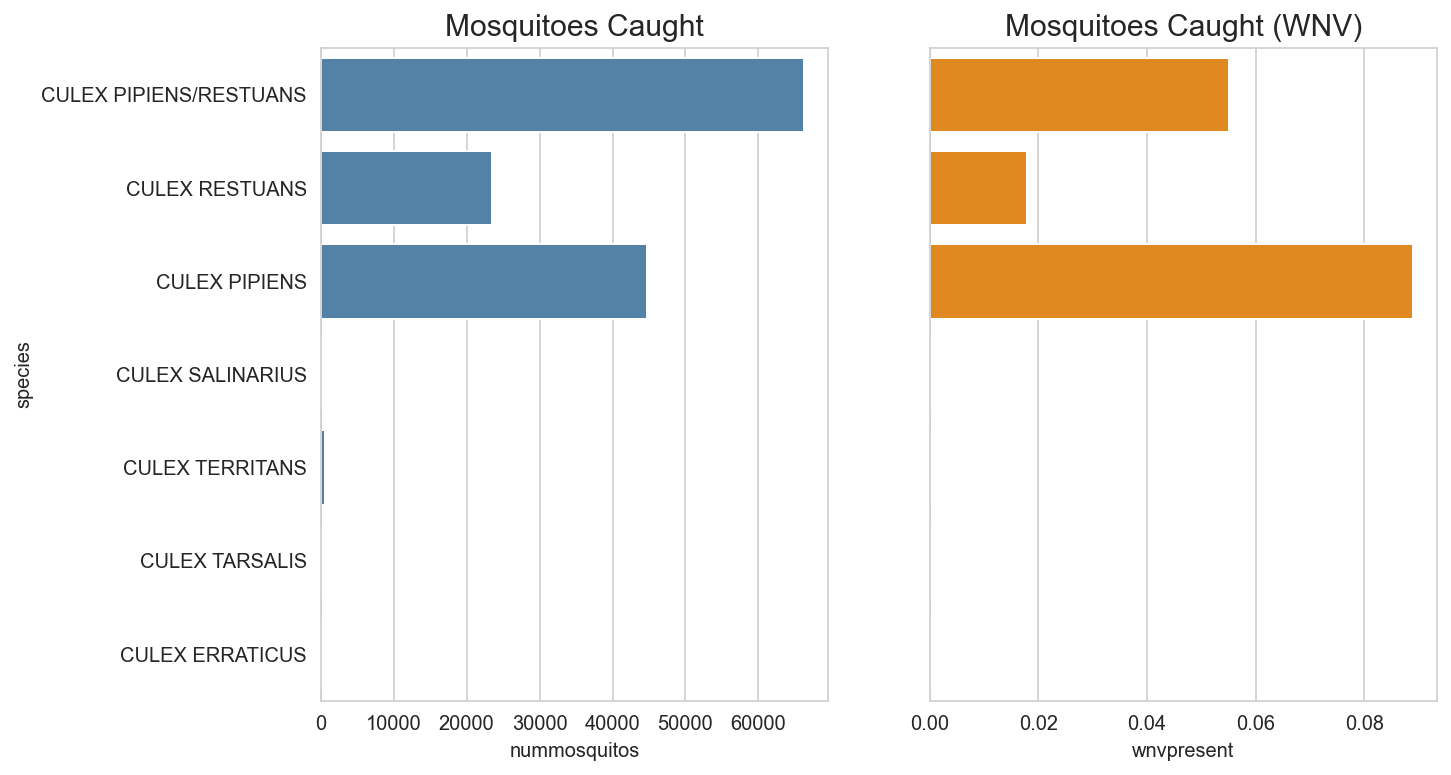

In [49]:
#plot WNV presence by species

plt.subplots(figsize=(10,6))
plt.subplot(1,2,1)
sns.barplot('nummosquitos','species',data=train, ci=None, estimator=sum, color='steelblue')
plt.title ("Mosquitoes Caught", fontsize=15)
plt.subplot(1,2,2)
sns.barplot('wnvpresent','species',data=train, ci=None, color='darkorange')
plt.yticks([])
plt.ylabel("")
plt.title ("Mosquitoes Caught (WNV)", fontsize=15);

In [50]:
# Species with WNV
train[train['wnvpresent'] == 1]['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS'],
      dtype=object)

Text(0, 0.5, 'wnvpresent')

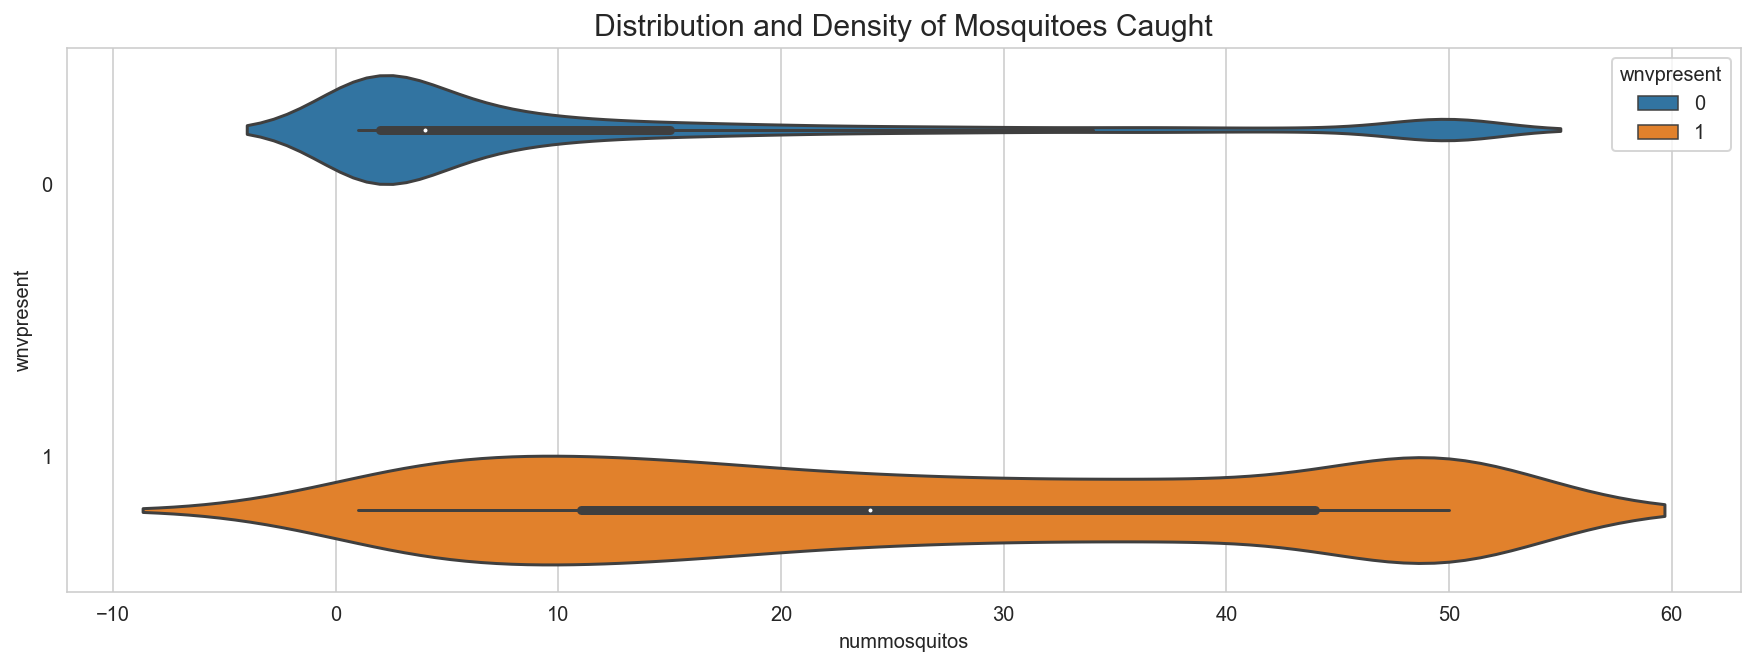

In [51]:
# plot distribution, skew and kernel density
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.violinplot(y= 'wnvpresent', 
                    x='nummosquitos',
                    data=train, 
                    orient='h', 
                    hue='wnvpresent')

ax.set_title('Distribution and Density of Mosquitoes Caught',fontsize=15)
ax.set_xlabel("nummosquitos")
ax.set_ylabel("wnvpresent")


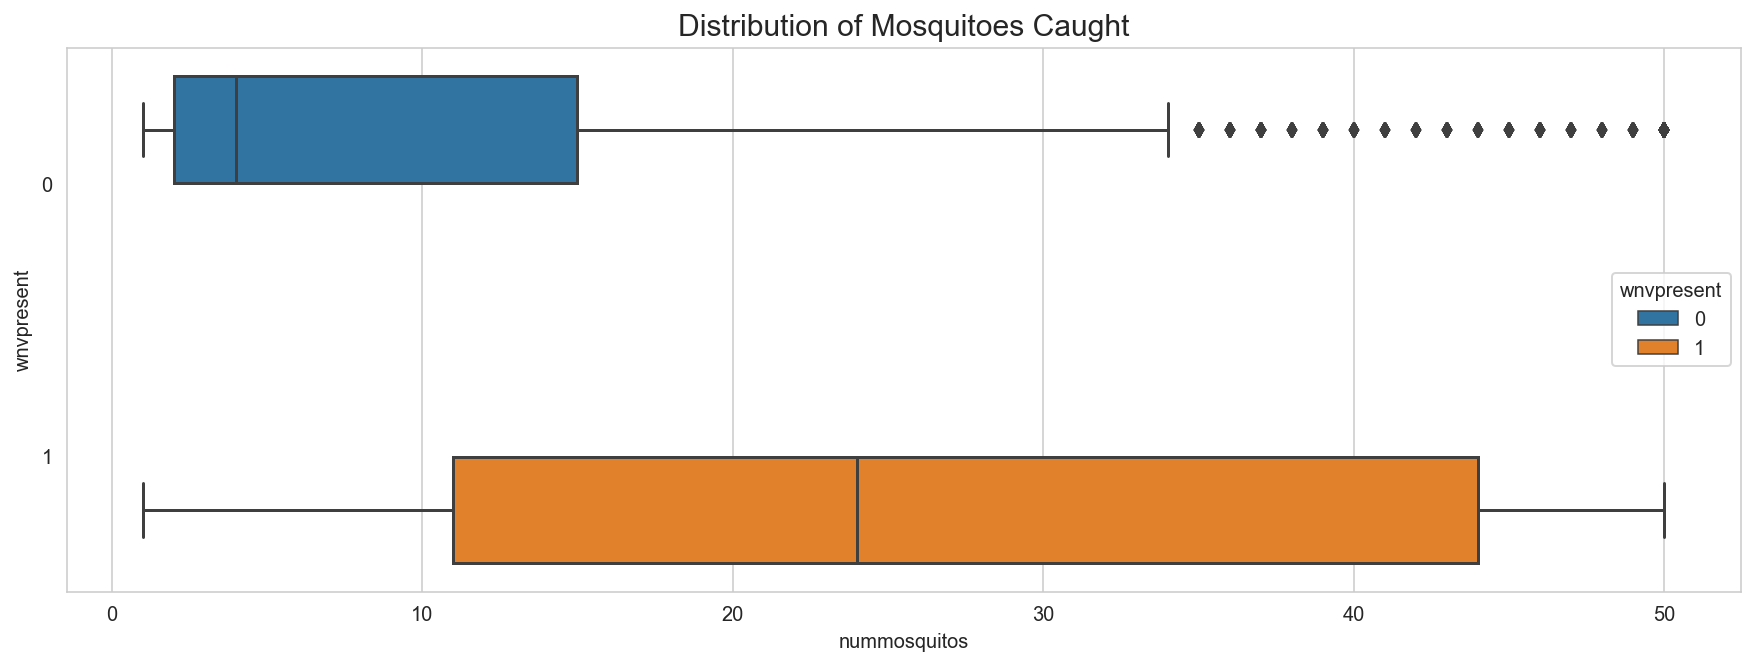

In [52]:
# plot distribution, skew and kernel density
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.boxplot(y= 'wnvpresent', 
                    x='nummosquitos',
                    data=train, 
                    orient='h', 
                    hue='wnvpresent')

ax.set_title('Distribution of Mosquitoes Caught',fontsize=15)
ax.set_xlabel("nummosquitos")
ax.set_ylabel("wnvpresent");


<div class="alert alert-block alert-info">
<b>Observations:</b>

- We can see from the distribution on the non-positve WNV that there is a right tail. However we know that the data for traps have a maximum cap of 50 mosquitoes, because the number is still in the range of 50, we will not count them as outliers. 
</div>

In [53]:
# Split dates into separate column 
split_date(train)
split_date(weather)
split_date(spray)

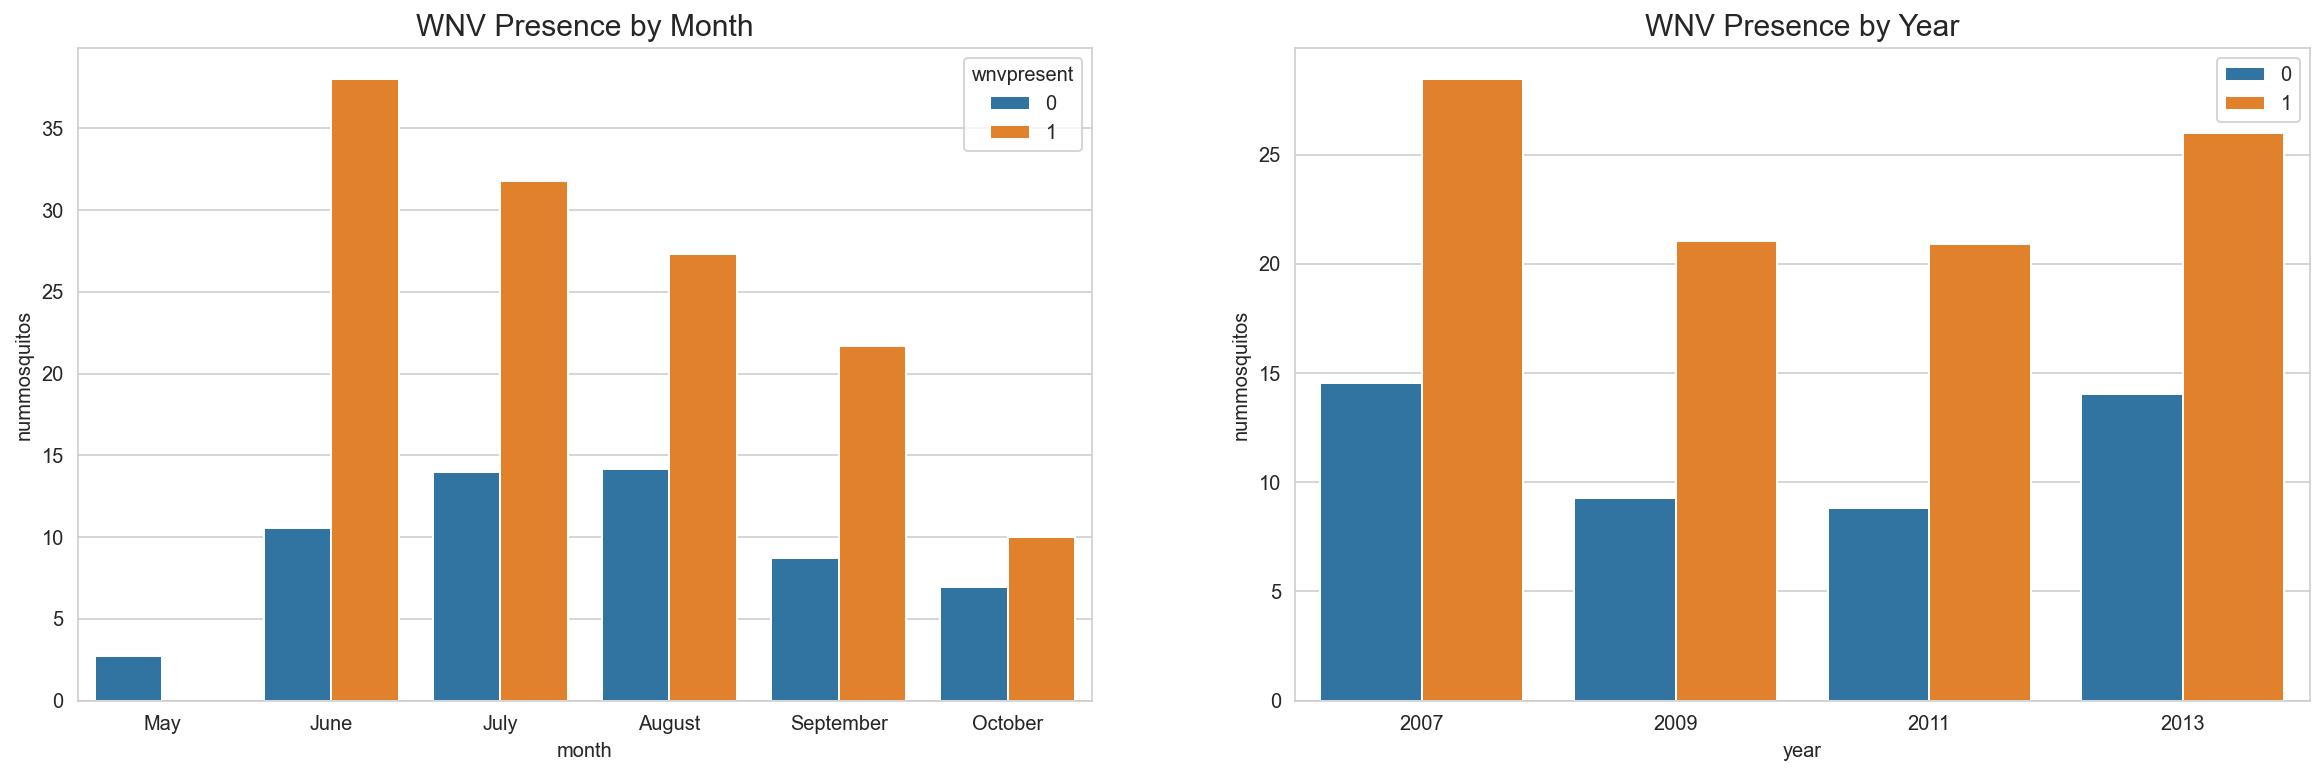

In [54]:
#plot WNV presence by month and year
plt.subplots(figsize=(20,6))
plt.subplot(1,2,1)
_=sns.barplot('month','nummosquitos',data=train,hue='wnvpresent', ci=None)
_.set(xticklabels=['May', 'June', 'July', 'August', 'September', 'October'])
plt.title ("WNV Presence by Month", fontsize=15)
plt.subplot(1,2,2)
sns.barplot('year','nummosquitos',data=train,hue='wnvpresent', ci=None)
plt.title ("WNV Presence by Year", fontsize=15)
plt.legend(loc=1);

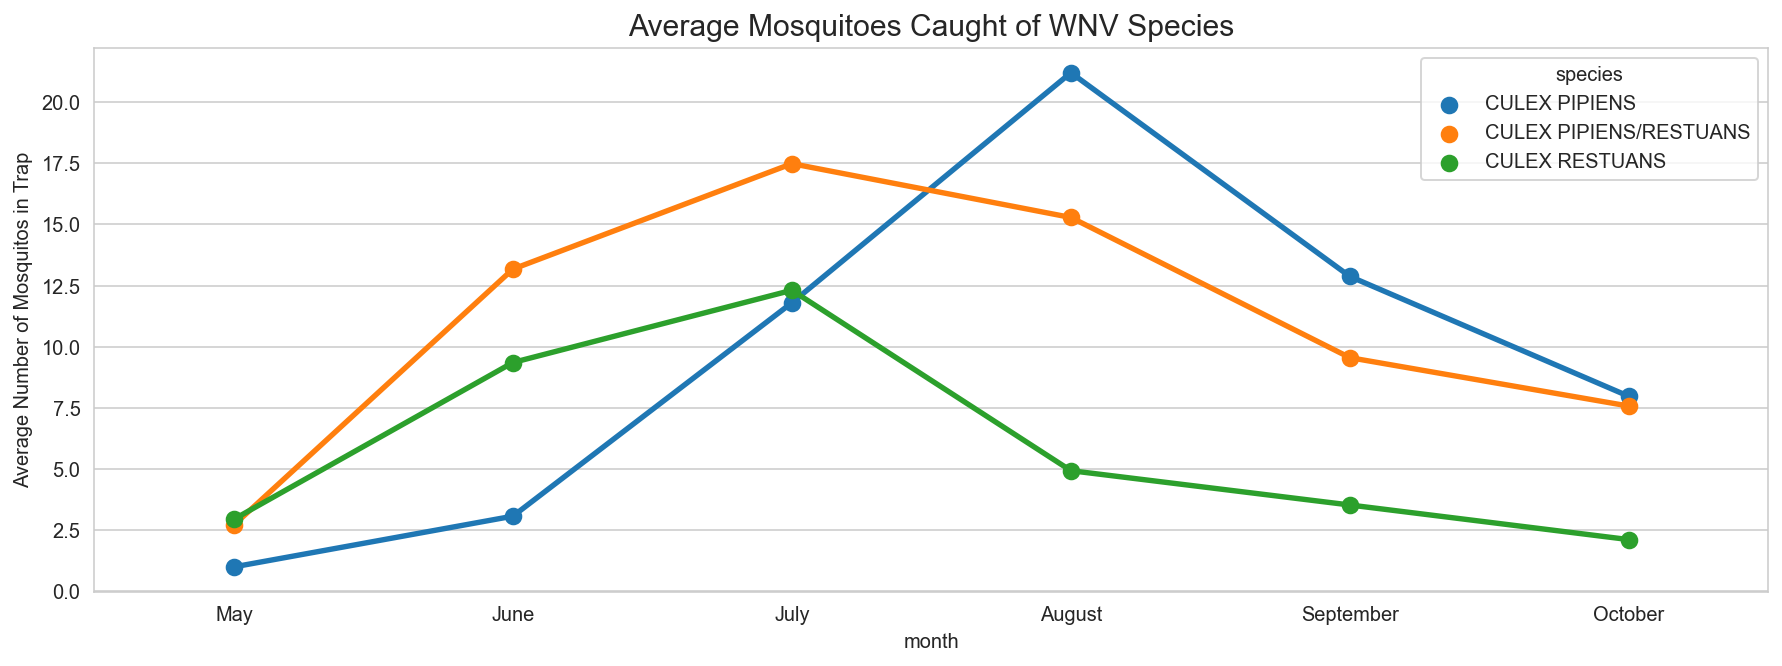

In [55]:
# plot mean mosquitoes caught in trap by month
plt.figure(figsize=(15,5))
_ = sns.pointplot(x='month', y="nummosquitos", hue='species', data=train[train['species'].isin(['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS'])].groupby(['month', 'species'], as_index=False)['nummosquitos'].mean(),)
_.set(xticklabels=['May', 'June', 'July', 'August', 'September', 'October'])
plt.ylabel('Average Number of Mosquitos in Trap')
plt.title("Average Mosquitoes Caught of WNV Species", fontsize=15);

<div class="alert alert-block alert-info">
<b>Observations:</b>

- MNV presence only starts in June
- Two out of three WNV carrier species peak in July instead of August
</div>

In [56]:
# combining mosquitoes maxed at 50, total mosquitoes
train[train.nummosquitos == 50]
train.groupby(['date', 'trap', 'species'], as_index=False)['nummosquitos'].sum().sort_values('nummosquitos', ascending=False)

date  trap                 species  nummosquitos
1450 2007-08-16  T115           CULEX PIPIENS          2532
565  2007-07-25  T115           CULEX PIPIENS          2356
1901 2007-08-28  T115           CULEX PIPIENS          2207
1196 2007-08-08  T138           CULEX PIPIENS          1658
2055 2007-09-05  T115           CULEX PIPIENS          1648
...         ...   ...                     ...           ...
2106 2007-09-12  T012  CULEX PIPIENS/RESTUANS             1
5302 2011-07-25  T047           CULEX PIPIENS             1
5301 2011-07-25  T046  CULEX PIPIENS/RESTUANS             1
5297 2011-07-25  T033          CULEX RESTUANS             1
0    2007-05-29  T002  CULEX PIPIENS/RESTUANS             1

[8475 rows x 4 columns]

In [57]:
# combining mosquitoes maxed at 50, total mosquitoes
train[train.nummosquitos == 50]
tot_mos = train.groupby(['date', 'trap', 'species'], as_index=False)['nummosquitos'].sum().sort_values('nummosquitos', ascending=False)

In [58]:
tot_mos.head()

date  trap        species  nummosquitos
1450 2007-08-16  T115  CULEX PIPIENS          2532
565  2007-07-25  T115  CULEX PIPIENS          2356
1901 2007-08-28  T115  CULEX PIPIENS          2207
1196 2007-08-08  T138  CULEX PIPIENS          1658
2055 2007-09-05  T115  CULEX PIPIENS          1648

In [59]:
# mosquitoes caught by address
rate = train.groupby(['addressnumberandstreet', 'trap'], as_index=False)['wnvpresent', 'nummosquitos'].sum().sort_values('wnvpresent')

In [60]:
rate.tail()

addressnumberandstreet  trap  wnvpresent  nummosquitos
79     4600  N MILWAUKEE AVE, Chicago, IL  T003          14          1346
4   1000  S STONY ISLAND AVE, Chicago, IL  T138          16          9936
72      4100  N OAK PARK AVE, Chicago, IL  T002          18          3710
18          1200  S DOTY AVE, Chicago, IL  T115          41         21668
7      1000  W OHARE AIRPORT, Chicago, IL  T900          66         15386

In [61]:
# add virus rate column to rate df
rate['rate_virus'] = rate['wnvpresent']/rate['nummosquitos']

In [62]:
# view traps and address by most WNV caught
rate.sort_values('wnvpresent', ascending=False).head(10)

addressnumberandstreet  trap  wnvpresent  nummosquitos  \
7       1000  W OHARE AIRPORT, Chicago, IL  T900          66         15386   
18           1200  S DOTY AVE, Chicago, IL  T115          41         21668   
72       4100  N OAK PARK AVE, Chicago, IL  T002          18          3710   
4    1000  S STONY ISLAND AVE, Chicago, IL  T138          16          9936   
79      4600  N MILWAUKEE AVE, Chicago, IL  T003          14          1346   
128       8200  S KOSTNER AVE, Chicago, IL  T225          11          2014   
60     3600  N PITTSBURGH AVE, Chicago, IL  T011          11          1311   
45           2400  E 105TH ST, Chicago, IL  T128          11          3315   
115        7000  N MOSELL AVE, Chicago, IL  T008          10          2668   
8               1000  W OHARE, Chicago, IL  T903          10          2327   

     rate_virus  
7      0.004290  
18     0.001892  
72     0.004852  
4      0.001610  
79     0.010401  
128    0.005462  
60     0.008391  
45     0.003318  
115    0.003748  
8      0.004297

In [63]:
# view traps and address by WNV rate
rate.sort_values('rate_virus', ascending=False).head(25)

addressnumberandstreet  trap  wnvpresent  \
99                     6000  W ROSCOE ST, Chicago, IL  T005           2   
97                  6000  N AVONDALE AVE, Chicago, IL  T006           4   
109                 6500  N OAK PARK AVE, Chicago, IL  T143           6   
123                   7900  W FOSTER AVE, Chicago, IL  T015           4   
125                      8100  E 91ST ST, Chicago, IL  T107           2   
89                       5200  S NORDICA, Chicago, IL  T070           2   
75                       4200  W 31ST ST, Chicago, IL  T036           1   
69                    4000  N AUSTIN AVE, Chicago, IL  T142           1   
111               6600  S KILPATRICK AVE, Chicago, IL  T156           1   
71                   4000  S DEARBORN ST, Chicago, IL  T081           3   
106             6400  S STONY ISLAND AVE, Chicago, IL  T077           1   
134  9300  S DR MARTIN LUTHER KING JR DR, Chicago, IL  T162           1   
76                       4200  W 65TH ST, Chicago, IL  T235           7   
105                      6300  W 64TH ST, Chicago, IL  T155           6   
34                      2000  E 111TH ST, Chicago, IL  T084           1   
107                    6400  W STRONG ST, Chicago, IL  T014           4   
20                   1300  N LARAMIE AVE, Chicago, IL  T230           7   
5                      1000  S VINCENNES, Chicago, IL  T089           4   
36                    2100  N LAWLER AVE, Chicago, IL  T154           2   
52                     3000  S HOYNE AVE, Chicago, IL  T035           1   
94                    5800  N PULASKI RD, Chicago, IL  T027           7   
79                 4600  N MILWAUKEE AVE, Chicago, IL  T003          14   
43                       2200  W 89TH ST, Chicago, IL  T096           6   
29                    1700  N PULASKI RD, Chicago, IL  T039           4   
41                       2200  W 51ST ST, Chicago, IL  T061           8   

     nummosquitos  rate_virus  
99             50    0.040000  
97            107    0.037383  
109           230    0.026087  
123           169    0.023669  
125            86    0.023256  
89             90    0.022222  
75             52    0.019231  
69             58    0.017241  
111            61    0.016393  
71            207    0.014493  
106            70    0.014286  
134            70    0.014286  
76            557    0.012567  
105           530    0.011321  
34             91    0.010989  
107           364    0.010989  
20            644    0.010870  
5             374    0.010695  
36            188    0.010638  
52             94    0.010638  
94            666    0.010511  
79           1346    0.010401  
43            578    0.010381  
29            404    0.009901  
41            840    0.009524

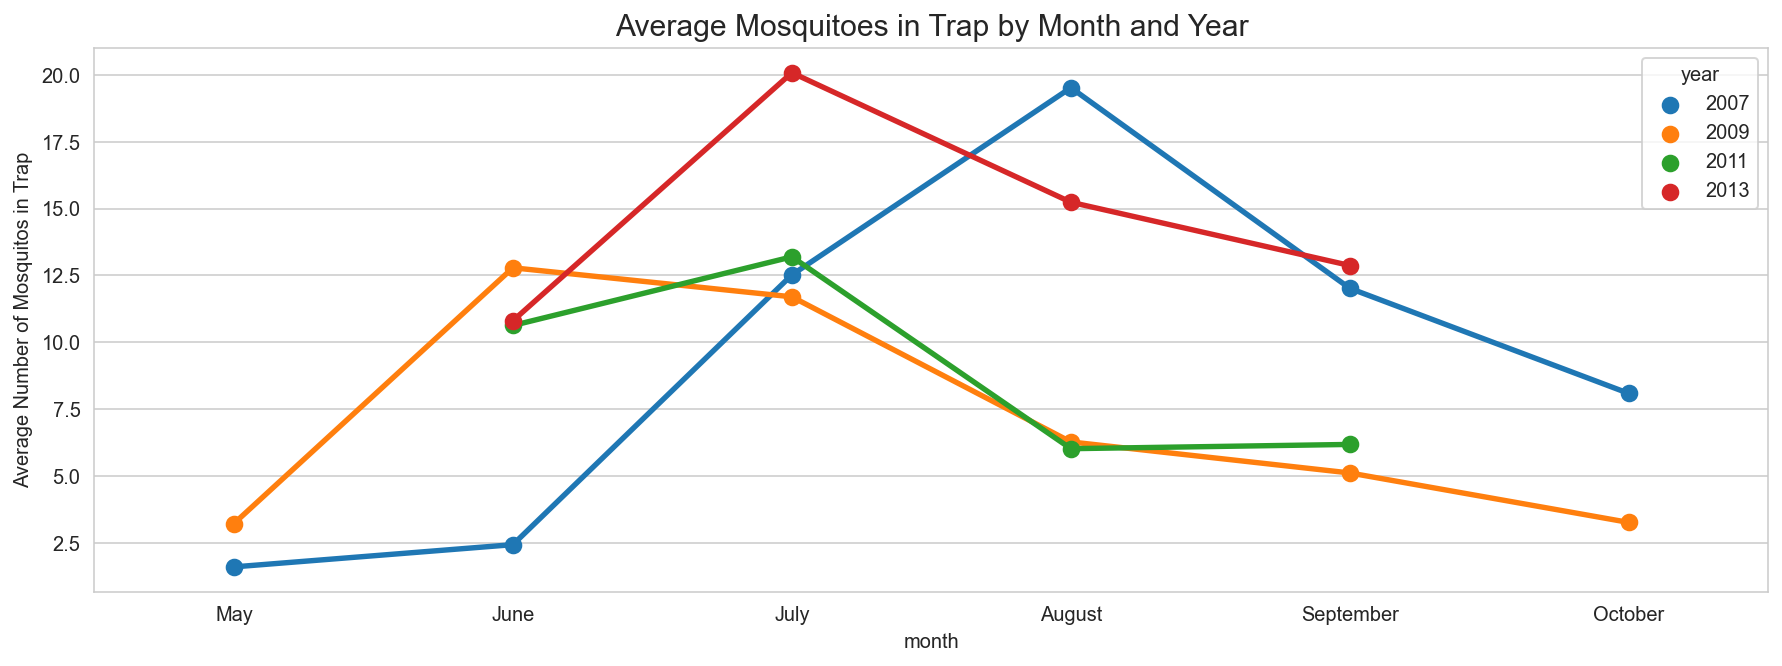

In [64]:
# plot Average Mosquitoes in Trap by Month and Year
plt.figure(figsize=(15,5))
_ = sns.pointplot(x='month', y="nummosquitos", hue="year", data=train.groupby(['year', 'month'], as_index=False)['nummosquitos'].mean(),)
_.set(xticklabels=['May', 'June', 'July', 'August', 'September', 'October'])
plt.ylabel('Average Number of Mosquitos in Trap')
plt.title('Average Mosquitoes in Trap by Month and Year', fontsize=15);

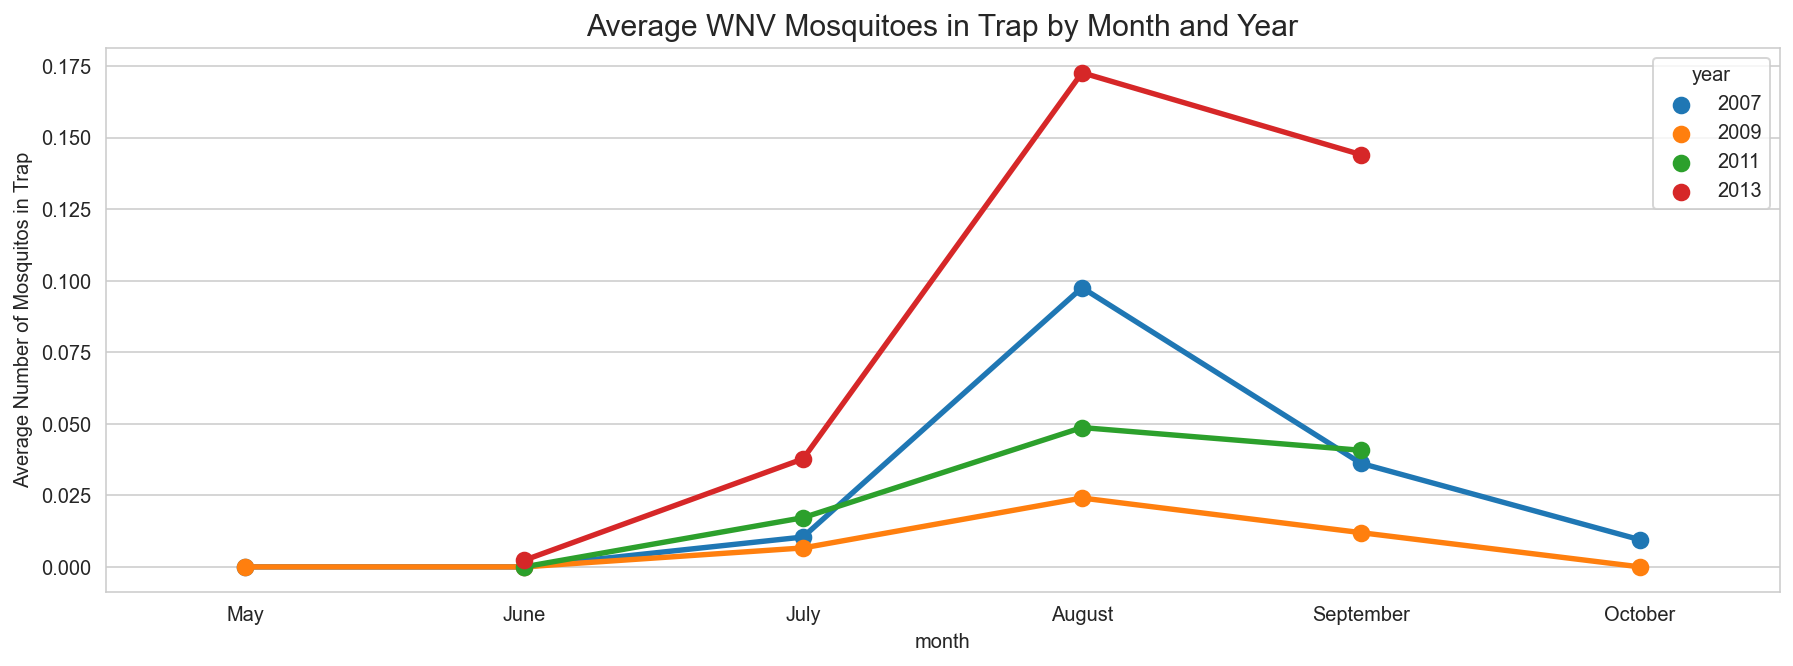

In [65]:
# plot Average WNV Mosquitoes in Trap by Month and Year
plt.figure(figsize=(15,5))
_ = sns.pointplot(x='month', y="wnvpresent", hue="year", data=train.groupby(['year', 'month'], as_index=False)['wnvpresent'].mean(),)
_.set(xticklabels=['May', 'June', 'July', 'August', 'September', 'October'])
plt.ylabel('Average Number of Mosquitos in Trap')
plt.title('Average WNV Mosquitoes in Trap by Month and Year', fontsize=15);

<div class="alert alert-block alert-info">
<b>Observations:</b>
    
- trend of peaking in August for WNV in all years even though mosquitoes caught all varies throughout May - October. 
- Since WNV come from birds, check migratory period for birds going through Chicago. 
</div>

In [66]:
# number of traps set by year
train.groupby('year')['trap'].count()

year
2007    3811
2009    2249
2011    2054
2013    2392
Name: trap, dtype: int64

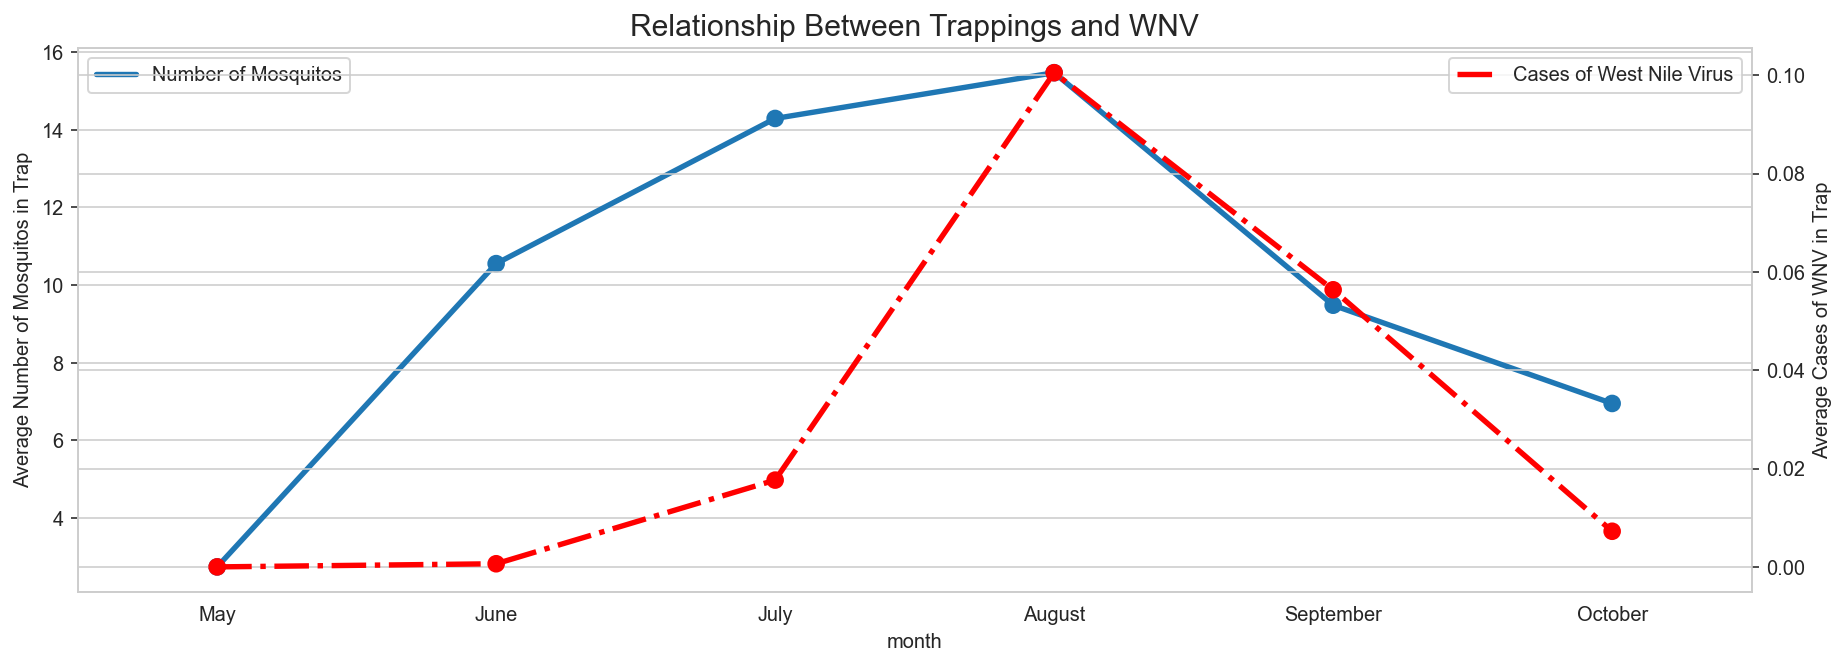

In [67]:
# relationship between trappings and WNV
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1 = sns.pointplot(x='month', y="nummosquitos", data=train.groupby(['month'], as_index=False)['nummosquitos'].mean(),)
plt.ylabel('Average Number of Mosquitos in Trap')
plt.legend(['Number of Mosquitos'], loc=2)
ax2 = ax1.twinx()
ax2 = sns.pointplot(x='month', y="wnvpresent", linestyles='-.', color='r', data=train.groupby(['month'], as_index=False)['wnvpresent'].mean(),)
ax1.set(xticklabels=['May', 'June', 'July', 'August', 'September', 'October'])
plt.ylabel('Average Cases of WNV in Trap')
plt.legend(['Cases of West Nile Virus'], loc=1)
plt.title('Relationship Between Trappings and WNV', fontsize=15);

<div class="alert alert-block alert-info">

<b>Feature Engineered:</b>
- "year", "month": Split date column into month and year column
- "total_mos": to combine multiple entries from nummosquitos that was above 50
- "rate_virus": 


<b>Observations:</b>

- There are a total of 7 species with culiex pipiens/restuans being the highest number of mosquito observation and the highest number of observation that is with WNV
- Majority class of WNV is not present.
- There is an unbalance distribution of target (Presence of WNV) in train datasets. Hence will have to stratify our target variable while doing train-test-split.
- With WnvPresent==0, there is quite a number of outliers
- Number of  mosquito fluctuates over the years but mosquito with wnv peaks in July and August but much more prevalent in 2007 & 2013.

</div>

***

##  Weather Dataset

In [68]:
# view dataset
weather.head().T

0                    1                    2  \
date           2007-05-01 00:00:00  2007-05-02 00:00:00  2007-05-03 00:00:00   
tmax_1                          83                   59                   66   
tmin_1                          50                   42                   46   
tavg_1                          67                   51                   56   
dewpoint_1                      51                   42                   40   
wetbulb_1                       56                   47                   48   
preciptotal_1                    0                    0                    0   
stnpressure_1                 29.1                29.38                29.39   
sealevel_1                   29.82                30.09                30.12   
resultspeed_1                  1.7                   13                 11.7   
resultdir_1                     27                    4                    7   
avgspeed_1                     9.2                 13.4                 11.9   
latitude_1                  41.995               41.995               41.995   
longitude_1                -87.933              -87.933              -87.933   
tmax_2                          84                   60                   67   
tmin_2                          52                   43                   48   
tavg_2                          68                   52                   58   
dewpoint_2                      51                   42                   40   
wetbulb_2                       57                   47                   50   
preciptotal_2                    0                    0                    0   
stnpressure_2                29.18                29.44                29.46   
sealevel_2                   29.82                30.08                30.12   
resultspeed_2                  2.7                 13.3                 12.9   
resultdir_2                     25                    2                    6   
avgspeed_2                     9.6                 13.4                 13.2   
latitude_2                  41.786               41.786               41.786   
longitude_2                -87.752              -87.752              -87.752   
year                          2007                 2007                 2007   
month                            5                    5                    5   

                                 3                    4  
date           2007-05-04 00:00:00  2007-05-05 00:00:00  
tmax_1                          66                   66  
tmin_1                          49                   53  
tavg_1                          58                   60  
dewpoint_1                      41                   38  
wetbulb_1                       50                   49  
preciptotal_1                0.005                0.005  
stnpressure_1                29.31                 29.4  
sealevel_1                   30.05                 30.1  
resultspeed_1                 10.4                 11.7  
resultdir_1                      8                    7  
avgspeed_1                    10.8                   12  
latitude_1                  41.995               41.995  
longitude_1                -87.933              -87.933  
tmax_2                          78                   66  
tmin_2                          51                   54  
tavg_2                          65                   60  
dewpoint_2                      42                   39  
wetbulb_2                       50                   50  
preciptotal_2                    0                0.005  
stnpressure_2                29.36                29.46  
sealevel_2                   30.04                30.09  
resultspeed_2                 10.1                 11.2  
resultdir_2                      7                    7  
avgspeed_2                    10.4                 11.5  
latitude_2                  41.786               41.786  
longitude_2                -87.752              -87.752  
year    

In [69]:
# additional columns 
weather['tempmax_avg'] = (weather['tmax_1'] + weather['tmax_2'])/2
weather['tempmin_avg'] = (weather['tmin_1'] + weather['tmin_2'])/2
weather['temp_avg'] = (weather['tavg_1'] + weather['tavg_2'])/2
weather['dewpoint_avg'] = (weather['dewpoint_1'] + weather['dewpoint_2'])/2
weather['wetbulb_avg'] = (weather['wetbulb_1'] + weather['wetbulb_2'])/2
weather['precip_avg'] = (weather['preciptotal_1'] + weather['preciptotal_2'])/2
weather['stnpressure_avg'] = (weather['stnpressure_1'] + weather['stnpressure_2'])/2

weather['maxtemp_2w'] = weather['tempmax_avg'].rolling(14, min_periods=1).min()
weather['maxtemp_4w'] = weather['tempmax_avg'].rolling(28, min_periods=1).min()
weather['maxtemp_90d'] = weather['tempmax_avg'].rolling(90, min_periods=1).mean()

weather['mintemp_2w'] = weather['tempmin_avg'].rolling(14, min_periods=1).min()
weather['mintemp_4w'] = weather['tempmin_avg'].rolling(28, min_periods=1).min()
weather['mintemp_90d'] = weather['tempmin_avg'].rolling(90, min_periods=1).mean()

weather['tavg_2w'] = weather['temp_avg'].rolling(14, min_periods=1).mean()
weather['tavg_4w'] = weather['temp_avg'].rolling(28, min_periods=1).mean()
weather['tavg_90d'] = weather['temp_avg'].rolling(90, min_periods=1).mean()

weather['dew_2w'] = weather['dewpoint_avg'].rolling(14, min_periods=1).mean()
weather['dew_4w'] = weather['dewpoint_avg'].rolling(28, min_periods=1).mean()
weather['dew_90d'] = weather['dewpoint_avg'].rolling(90, min_periods=1).sum()

weather['wetbulb_2w'] = weather['wetbulb_avg'].rolling(14, min_periods=1).mean()
weather['wetbulb_4w'] = weather['wetbulb_avg'].rolling(28, min_periods=1).mean()
weather['wetbulb_90d'] = weather['wetbulb_avg'].rolling(90, min_periods=1).sum()

weather['precip_2w'] = weather['precip_avg'].rolling(14, min_periods=1).sum()
weather['precip_4w'] = weather['precip_avg'].rolling(28, min_periods=1).sum()
weather['precip_90d'] = weather['precip_avg'].rolling(90, min_periods=1).sum()

In [70]:
# calculate humidity
weather['relative_humidity'] = weather.apply(humidity_calc, axis = 1)

In [71]:
# Merge train and weather dataset
train = pd.merge(train, weather, how='left', on=['date','month','year'])

# Save Merged DataFrame
train.to_csv("../assets/train_weather.csv")

***

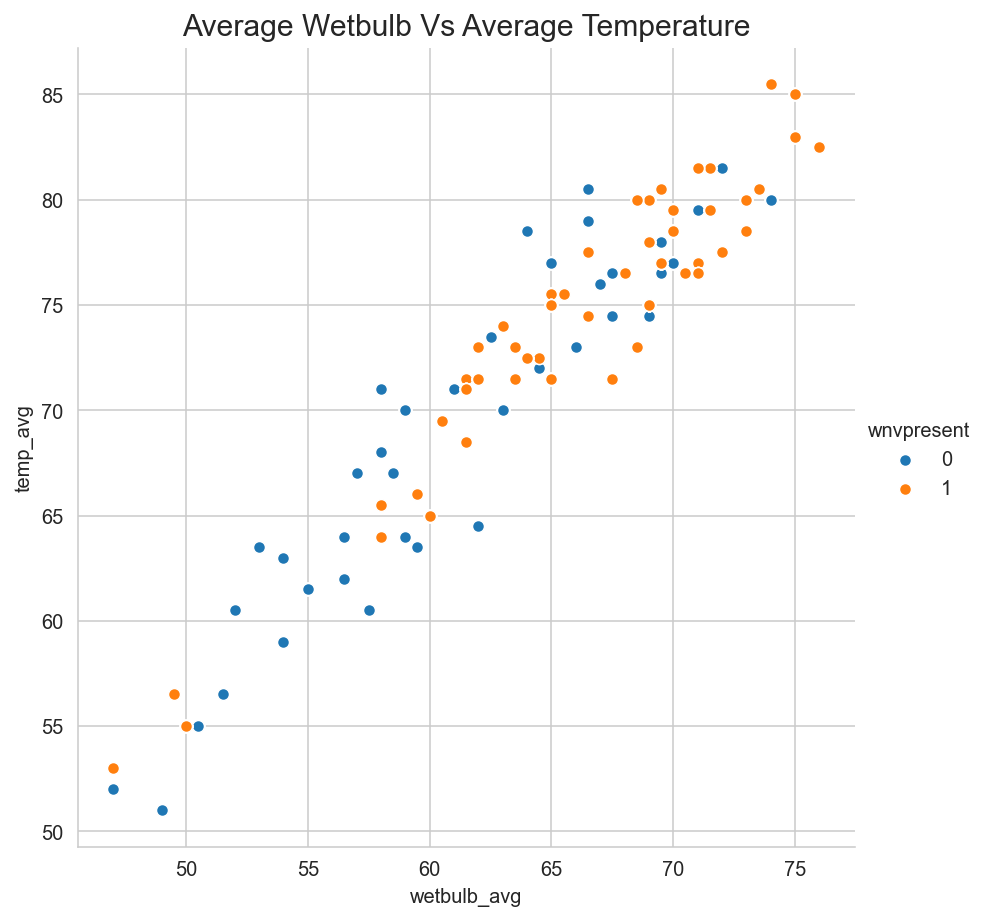

In [72]:
# corr between plot wetbulb vs mean temperature
sns.pairplot(data=train, 
             x_vars='wetbulb_avg', 
             y_vars='temp_avg', 
             hue='wnvpresent', 
             size=6)
plt.title("Average Wetbulb Vs Average Temperature", fontsize=15);

<div class="alert alert-block alert-info">

<b>Observations:</b>
- There's a positive correlation between average temperature and  the wetbulb temperature with the presence of WNV. With higher temperature and drier air correlates with the increase of mosquito with WNV 

</div>

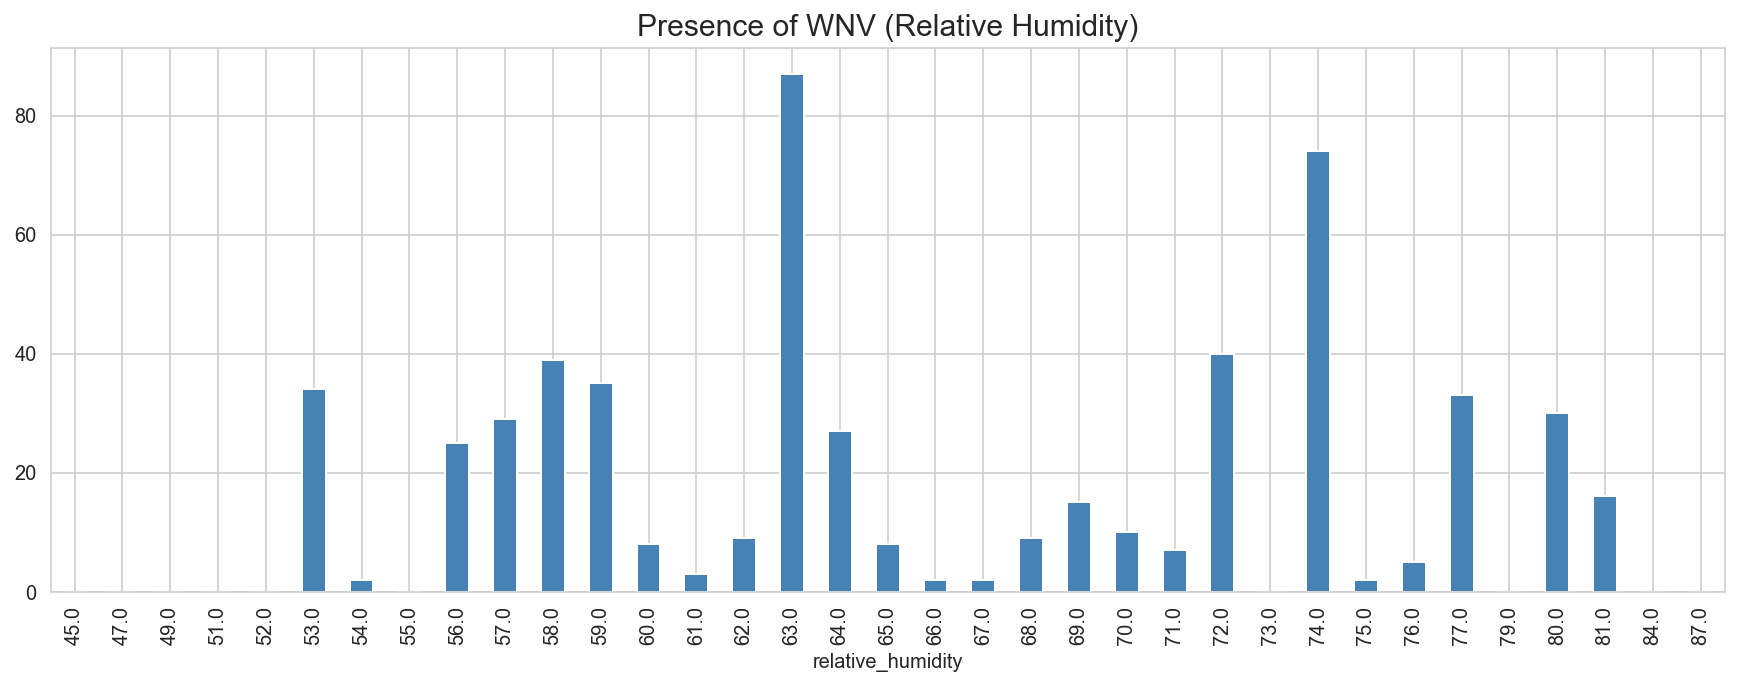

In [99]:
# plot humidity and WNV presence
plt.figure(figsize=(15,5))
train.groupby(['relative_humidity'])['wnvpresent'].sum().plot.bar(color="steelblue")
plt.title("Presence of WNV (Relative Humidity)", fontsize=15);

<div class="alert alert-block alert-info">

<b>Observations:</b>
- Although there might not be any particular trend here. But it seems like 63 and 74 might be the optimal humidity to have the virus. And as shown in the previous graph, drier air shows higher number of mosquitos with WNV

</div>

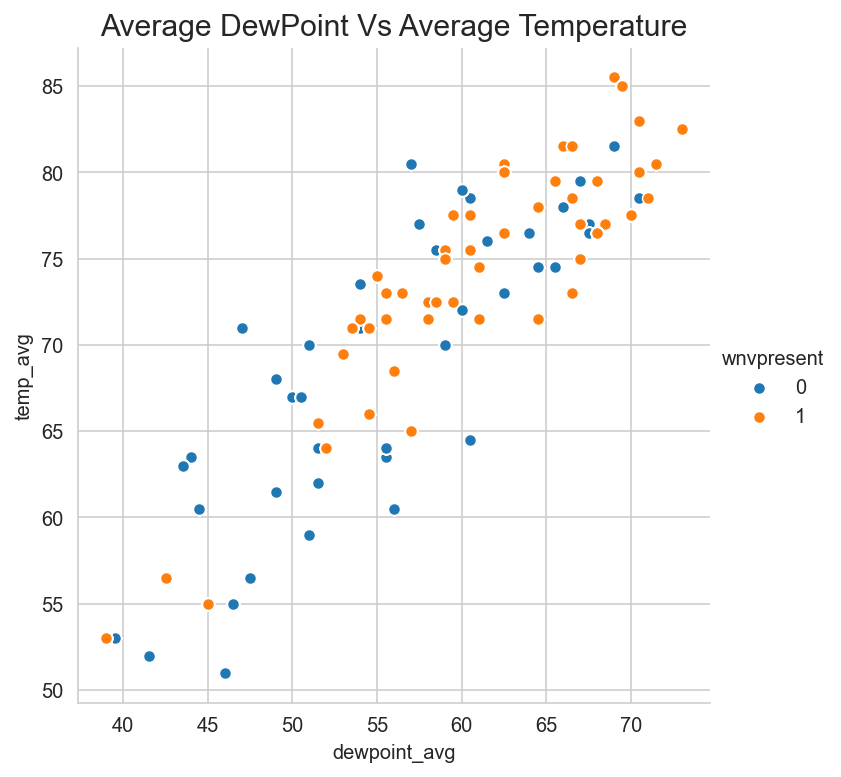

In [74]:
# corr between mean Dewpoint vs mean temp
sns.pairplot(data=train, 
             x_vars='dewpoint_avg', 
             y_vars='temp_avg', 
             hue='wnvpresent', 
             size=5)
plt.title("Average DewPoint Vs Average Temperature", fontsize=15);

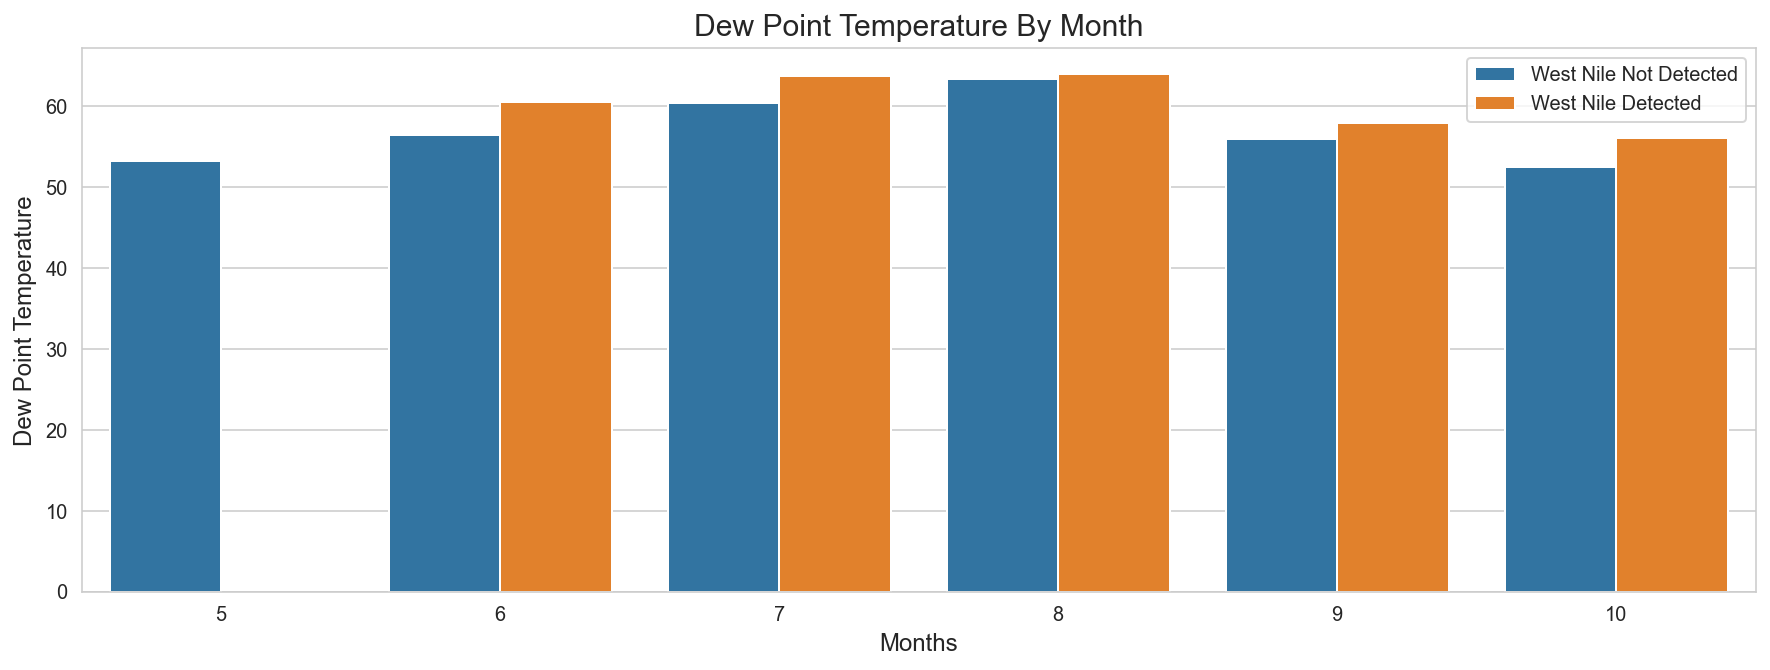

In [75]:
# plot WNV and dewpoint by month
plt.figure(figsize=(15,5))
sns.barplot(x='month', y='dewpoint_avg', data=train, hue='wnvpresent', ci=False)
plt.title("Dew Point Temperature By Month", fontsize=15)
plt.xlabel("Months", fontsize ='large')
plt.ylabel("Dew Point Temperature", fontsize='large')
plt.xticks(rotation=0)

L = plt.legend(loc="upper right")
L.get_texts()[0].set_text('West Nile Not Detected')
L.get_texts()[1].set_text('West Nile Detected')

<div class="alert alert-block alert-info">

<b>Observations:</b>

- More Mosquitos with West Nile Virus are detected during days with hotter temperatures with higher dew point
</div>


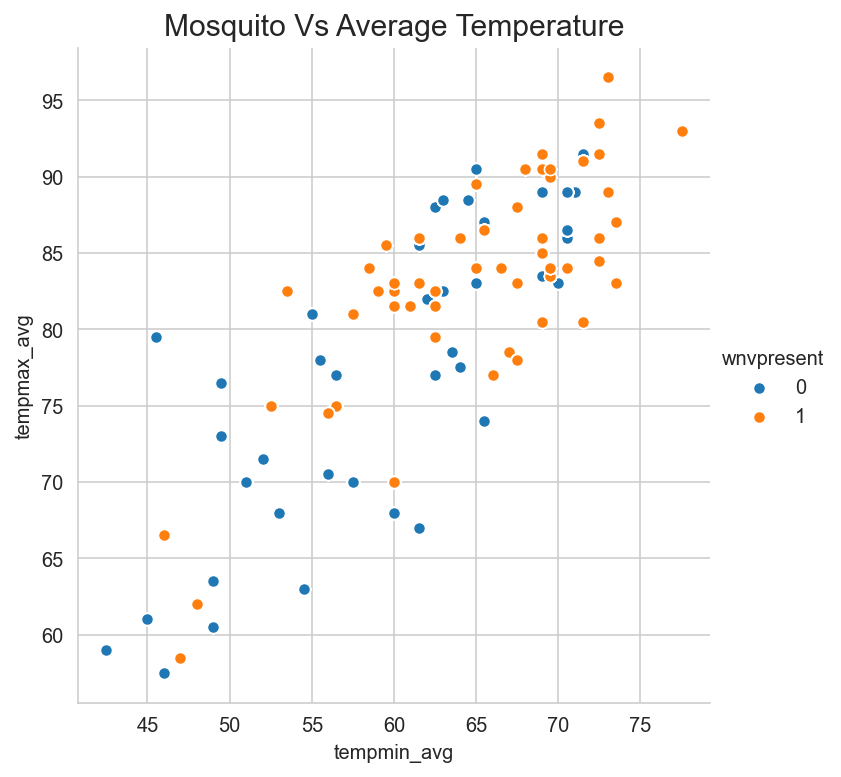

In [76]:
# corr between mosquitoes and avg temp
sns.pairplot(data=train, 
             x_vars='tempmin_avg', 
             y_vars='tempmax_avg', 
             hue='wnvpresent', 
             size=5)
plt.title("Mosquito Vs Average Temperature", fontsize=15);

<div class="alert alert-block alert-info">

<b>Observations:</b>

- Presence of WNV is evident when Average Temperature is above 70 Degrees Fahrenheit and DewPoint is above 55 Degrees Fahrenheit, hence more mosquito with WNV during days with higher humidity
</div>


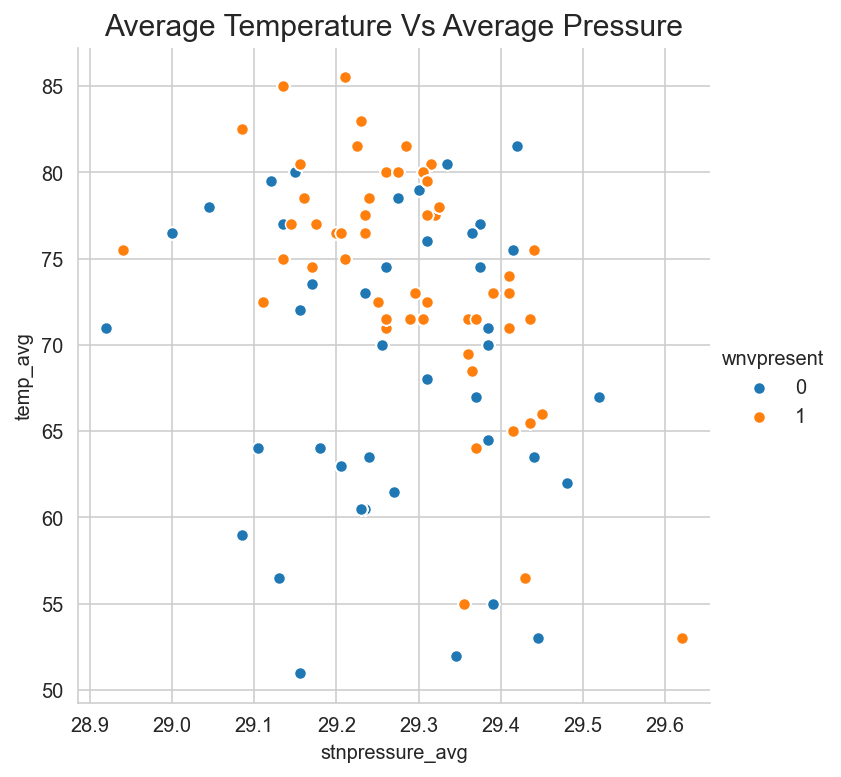

In [77]:
# corr between avg temp and avg pressure
sns.pairplot(data=train, 
             x_vars='stnpressure_avg', 
             y_vars='temp_avg', 
             hue='wnvpresent', 
             size=5)
plt.title("Average Temperature Vs Average Pressure", fontsize=15);

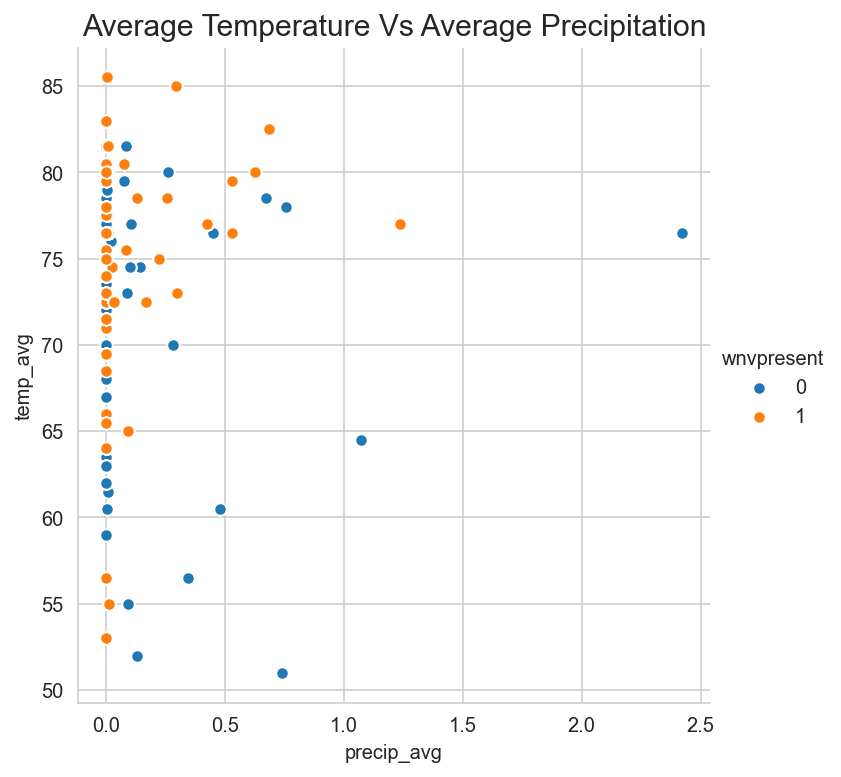

In [78]:
# corr between avg temp and avg precep
sns.pairplot(data=train, 
             x_vars='precip_avg', 
             y_vars='temp_avg', 
             hue='wnvpresent', 
             size=5)
plt.title("Average Temperature Vs Average Precipitation", fontsize=15);

<div class="alert alert-block alert-info">

<b>Feature Engineered:</b>
- Average of station 1 and 2 for columns and the average for 14, 28 and 90 days
    - "maxtemp",
    - "mintemp",
    - "tempavg",
    - "dewpoint",
    - "wetbulb",
    - "precip",
    - "stnpressure"
- relative_humidity

</div>

****

## Spray Dataset</span>


In [79]:
#view dataset
spray.head()

date  time   latitude  longitude  year  month
0 2011-08-29  18.0  42.391623 -88.089163  2011      8
1 2011-08-29  18.0  42.391348 -88.089163  2011      8
2 2011-08-29  18.0  42.391022 -88.089157  2011      8
3 2011-08-29  18.0  42.390637 -88.089158  2011      8
4 2011-08-29  18.0  42.390410 -88.088858  2011      8

In [80]:
# view spray dates
print(spray["date"].nunique())
spray["date"].value_counts()

10


2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2013-07-25    1607
2013-08-22    1587
2011-09-07    1573
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: date, dtype: int64

<div class="alert alert-block alert-info">
<b>Observations:</b>
    
- There were a total of 10 unique sprays dates which occur in both 2011 and 2013. 
On top of that we could see the total number of sprays made on those unique date. Hence we shall look at the location of these spray in this two years
</div>

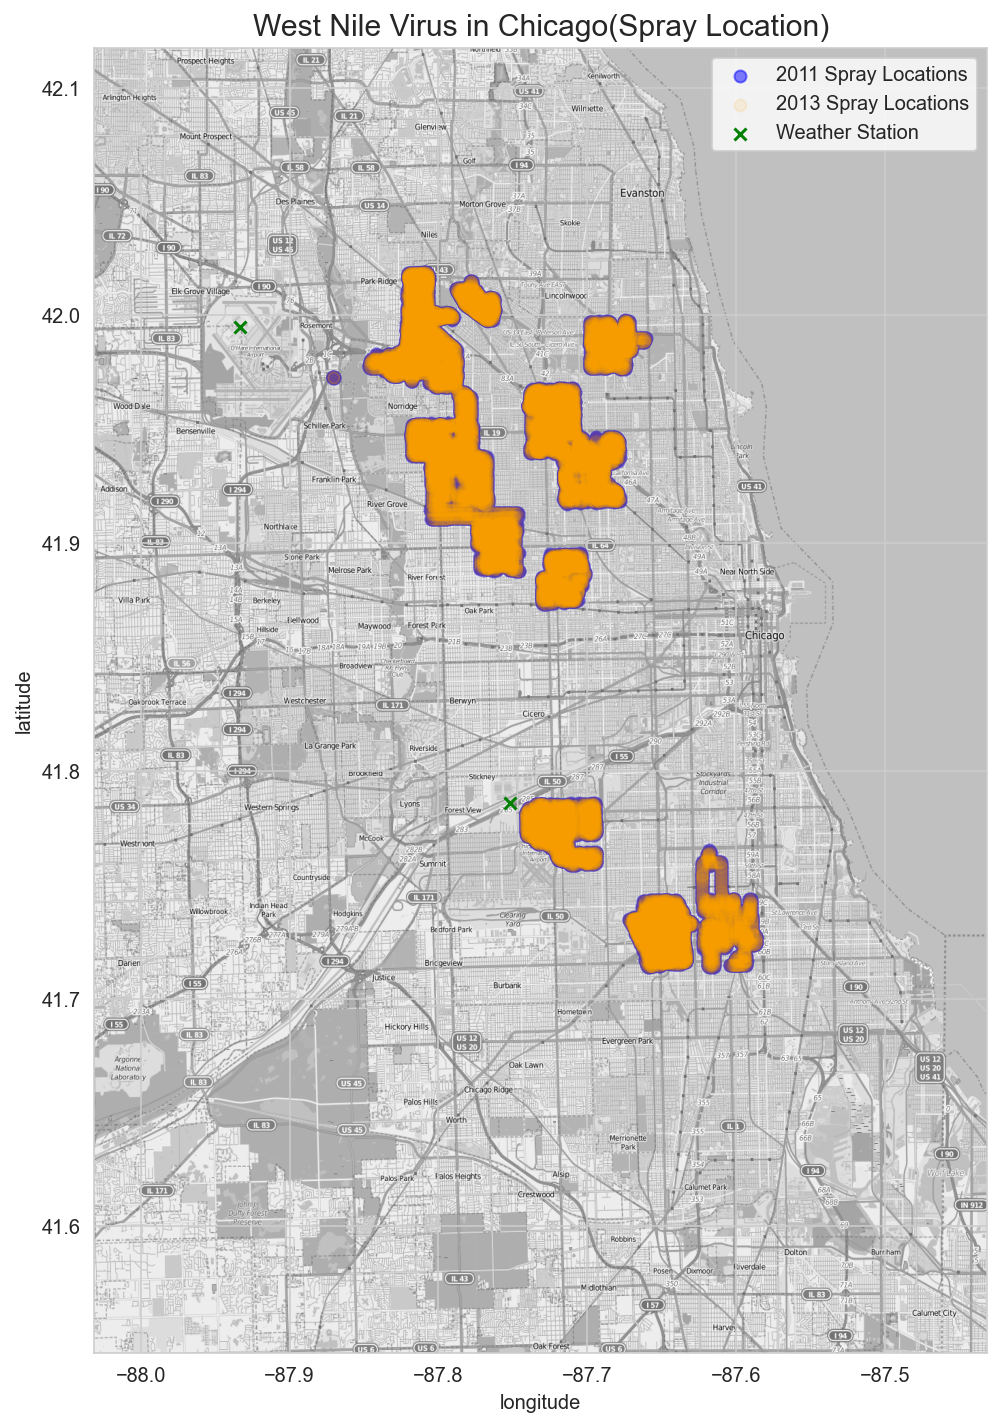

In [109]:
#plot spray area overlaps

spray_2011 = spray[spray['year'] == 2011]
spray_2013 = spray[spray['year'] == 2013]

# use map data provided by kaggle
mapdata = np.loadtxt('../assets/mapdata_copyright_openstreetmap_contributors.txt')  
lon_lat_box = (train['longitude'].min()-.1, 
               train['longitude'].max()+.1, 
               train['latitude'].min()-.1, 
               train['latitude'].max()+.1)

# Plot map
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box) 

# Spray locations
sprays = spray[['longitude', 'latitude']]
sprays_2011 = spray_2011[['longitude', 'latitude']]
sprays_2013 = spray_2013[['longitude', 'latitude']]
sprays_2011 = sprays[sprays['latitude'] < 42.3]  #outliers excluded
sprays_2013 = sprays[sprays['latitude'] < 42.3] 


plt.scatter(sprays_2011['longitude'], 
            sprays_2011['latitude'], 
            marker='o', 
            color='blue',
            alpha=.5, 
            label='2011 Spray Locations')

plt.scatter(sprays_2013['longitude'], 
            sprays_2013['latitude'], 
            marker='o', 
            color='orange',
            alpha=.1, 
            label='2013 Spray Locations')

# Weather stations
plt.scatter(x = (-87.933, -87.752), 
            y = (41.995, 41.786), 
            marker='x', 
            color='g', 
            label='Weather Station')

plt.title('West Nile Virus in Chicago(Spray Location)', size=15)
plt.legend(frameon=1)
plt.xlabel('longitude')
plt.ylabel('latitude');

<div class="alert alert-block alert-info">
<b>Observations:</b>
    
- Sprayed location of 2011 and 2013 showed minimal or no change.

</div>

In [82]:
# trap data type
train.trap.dtype

dtype('O')

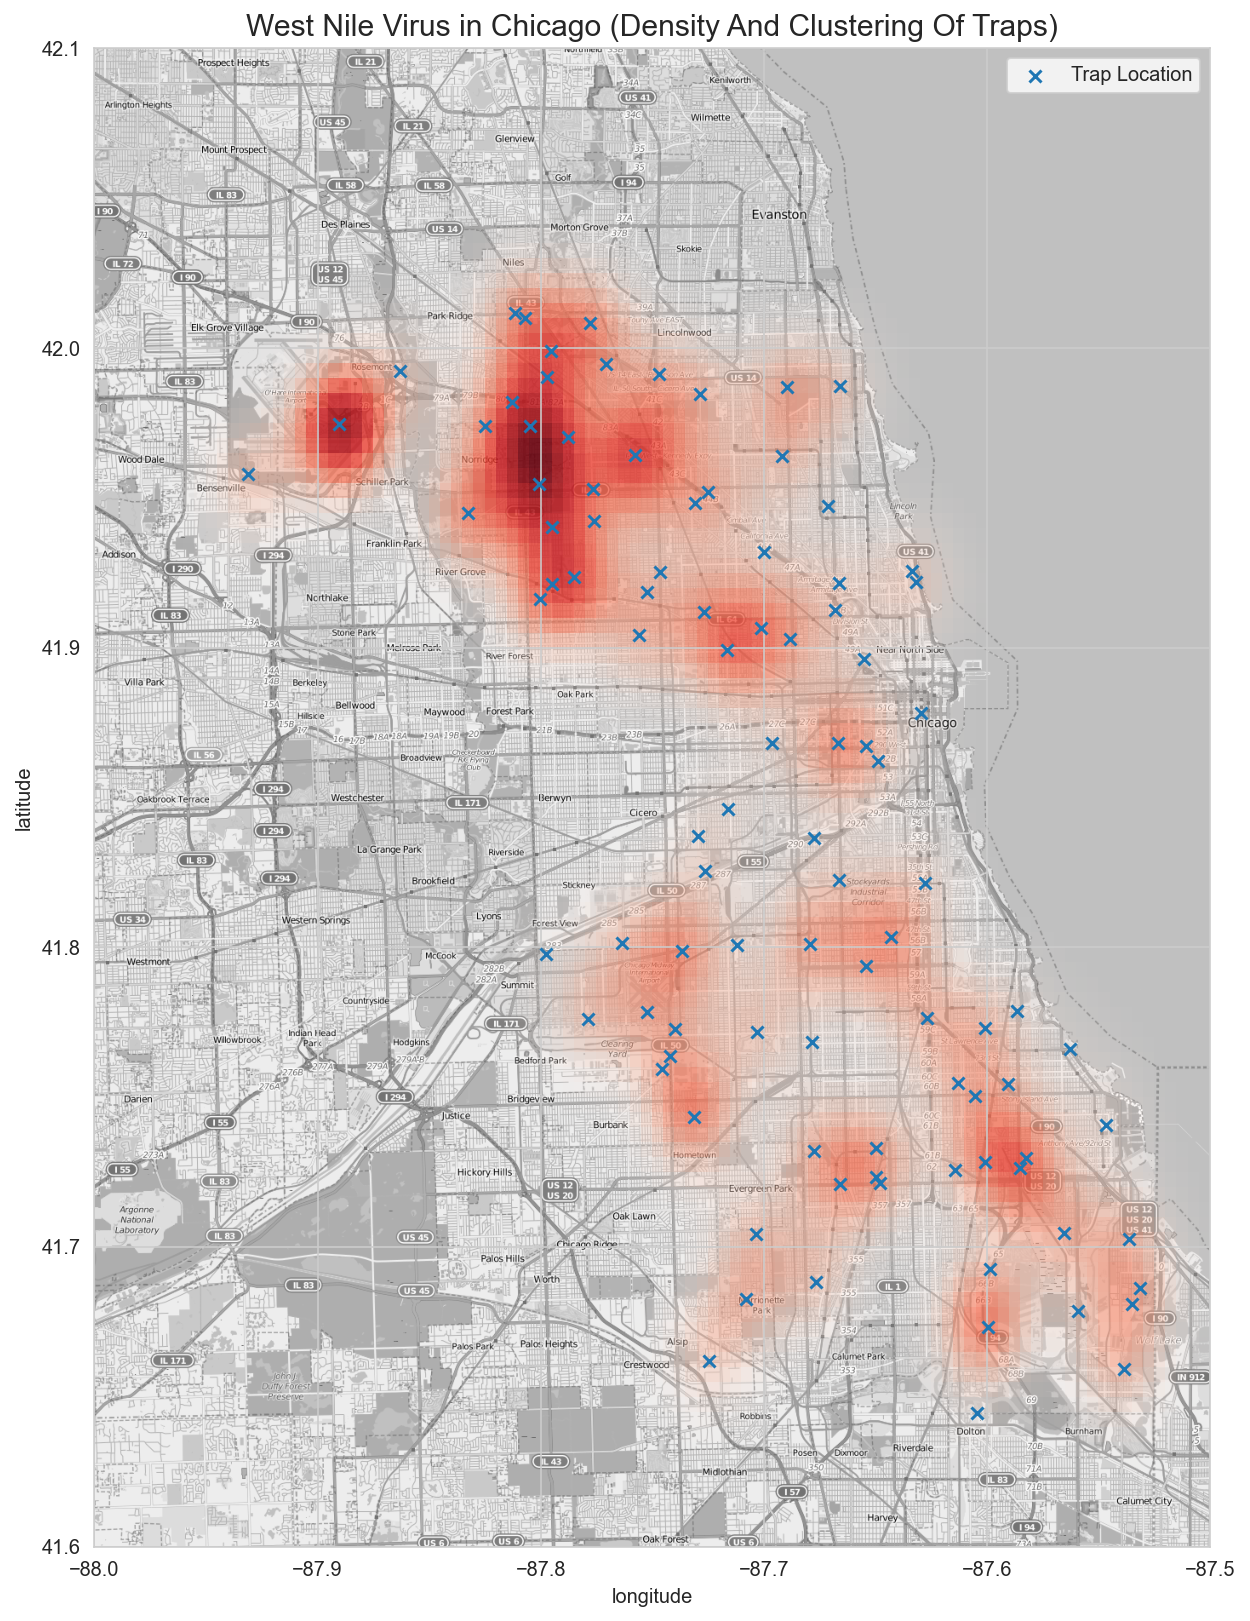

In [83]:
# plot density and clustering of traps



alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
sigthings = train[train['wnvpresent'] == 1]
sigthings = sigthings.groupby(['date', 'trap','longitude', 'latitude']).max()['wnvpresent'].reset_index()
X = sigthings[['longitude', 'latitude']].values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

#Trap locations
locations = sigthings[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Trap Location')


plt.title('West Nile Virus in Chicago (Density And Clustering Of Traps)',size=15)
plt.legend(frameon=1)
plt.xlabel('longitude')
plt.ylabel('latitude');


In [84]:
spray.head(1)

date  time   latitude  longitude  year  month
0 2011-08-29  18.0  42.391623 -88.089163  2011      8

<div class="alert alert-block alert-info">
<b>Observations:</b>

- This identify the density traps with mosquitos with WNV. Darker red areas indicates more mosquitoes with the virus and lighter red indicates less mosquito with the virus. Hence, darker read areas tend to have more priority.
    
Since the spraying occurs based on distance, DBSCAN seems the most appropriate as it does really well when there is clear "separation" within the dataset. Also as data uses coordinates for this clustering they should be of the same scale hence, no scaling should be required here.
</div>

Silhouette Score: 0.4937448338684894
Number of outliers: 5 (0.03% of samples)
Number of clusters: 8


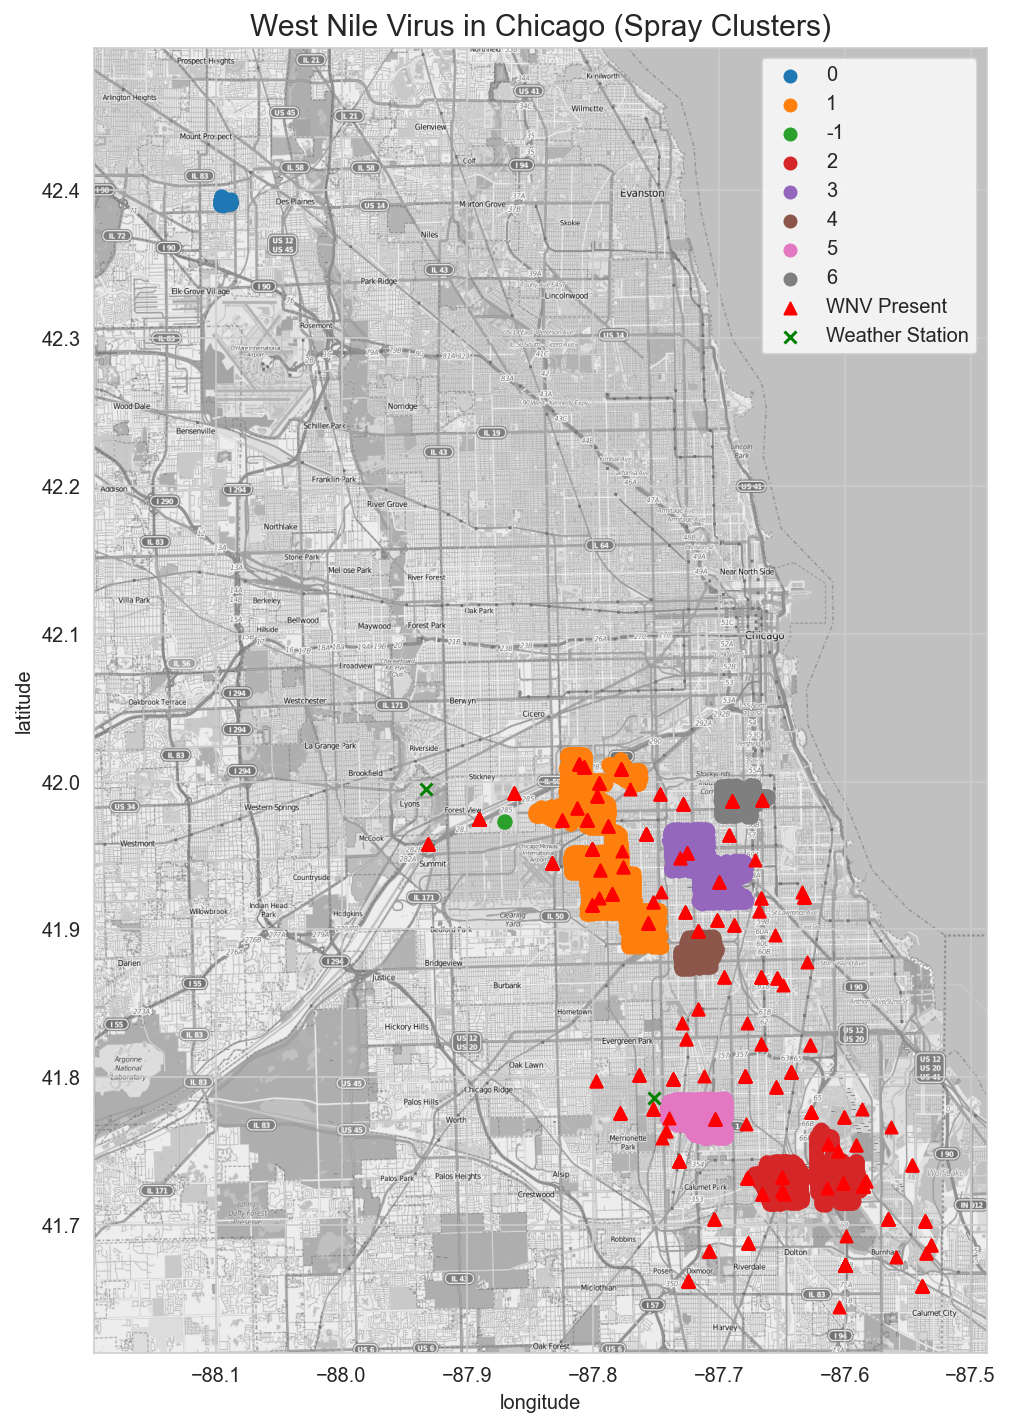

In [85]:
# use DBSCAN to cluster spray data to use to create spray cluster feature

# isolate the coordinates
X_spray = spray[['latitude', 'longitude']] 

minmax = MinMaxScaler(feature_range = (0, 1))
clusters = minmax.fit_transform(X_spray)

# run DBSCAN (parameters set after multiple iterations)
dbscan = DBSCAN(eps=.01, min_samples=20).fit(X_spray) 
# assign the clusters to original DataFrame.
X_spray['cluster'] = dbscan.labels_ 
vals = X_spray['cluster'].value_counts()

print(f'Silhouette Score: {silhouette_score(clusters, dbscan.labels_)}')
print(f'Number of outliers: {vals[-1]} ({vals[-1] * 100 / len(X_spray):.2f}% of samples)')
print(f'Number of clusters: {len(vals)}')

# set dimensions of plot
lon_lat_box_spray = (X_spray['longitude'].min()-.1, X_spray['longitude'].max()+.1, 
                     X_spray['latitude'].min()-.1,X_spray['latitude'].max()+.1)

# create plot of spray clusters, for loop allows for legend to represent clusters 
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box_spray) 

# iterate through each cluster value and plot points in the same figure (maintains lables)
for i in X_spray['cluster'].unique():  
    ax.scatter(X_spray[X_spray['cluster'] == i]['longitude'], 
               X_spray[X_spray['cluster'] == i]['latitude'], 
               label=i, marker='o')

# WNV presence
plt.scatter(train[train['wnvpresent'] == 1]['longitude'], 
            train[train['wnvpresent'] == 1]['latitude'], 
            marker='^', label='WNV Present', color='r')

# Weather stations
# Station 1: Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
plt.scatter(x = (-87.933, -87.752), 
            y = (41.995, 41.786), 
            marker='x', 
            color='g', 
            label='Weather Station')

plt.legend(frameon=1)
plt.title('West Nile Virus in Chicago (Spray Clusters)', size=15)
plt.xlabel('longitude')
plt.ylabel('latitude');

<div class="alert alert-block alert-info">
<b>Observations:</b>

- The spray cluster graph shows the number of possible clusters where spray occured, with a silhouette score of 0.49 (the closer the score is to 1 the better the clusters are well separated.) 
However there is one cluster that is way out of the norm that could be the outliers.

</div>

Silhouette Score: 0.4937448338684894


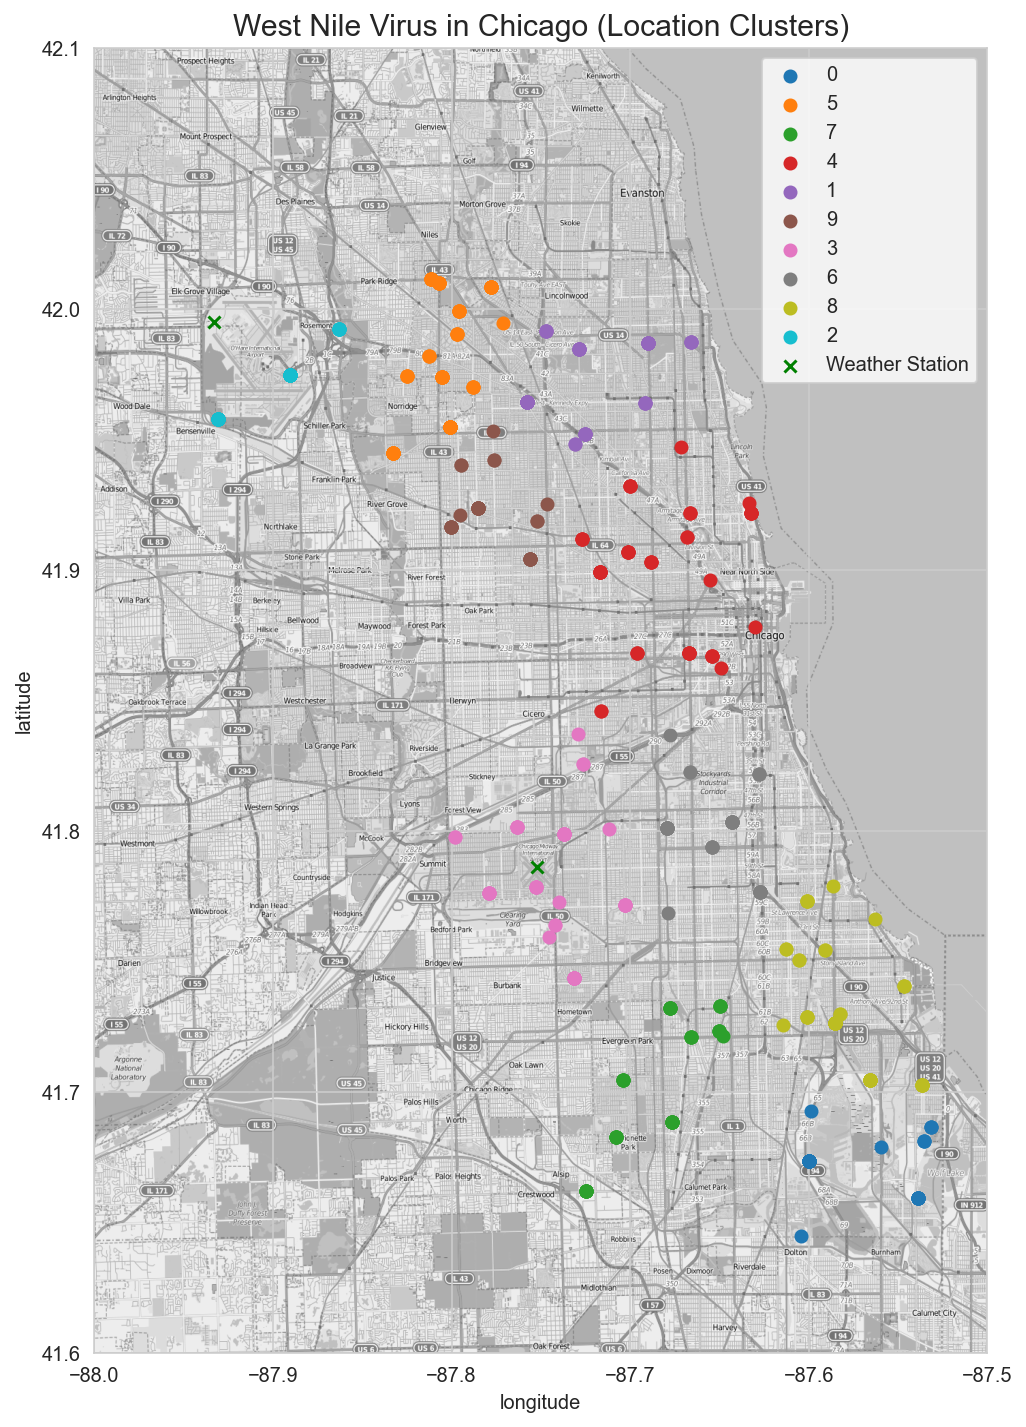

In [86]:
# plot WNV clusters

# isolate positive WNV traps
X_clusters = train[train['wnvpresent'] == 1][['latitude', 'longitude']] 

# create clustering model with KMeans
# 10 clusters selected after a few iterations and reviewing plot below
km = KMeans(n_clusters=10).fit(X_clusters) 
# assign the clusters to original DataFrame.
X_clusters['cluster'] = km.labels_ 

print(f'Silhouette Score: {silhouette_score(clusters, dbscan.labels_)}')

# plot map
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box) 
# iterate through each cluster value and plot points in the same figure (maintains lables)
for i in X_clusters['cluster'].unique(): 
    ax.scatter(X_clusters[X_clusters['cluster'] == i]['longitude'], 
               X_clusters[X_clusters['cluster'] == i]['latitude'], 
               label=i, marker='o')
    
plt.scatter(x = (-87.933, -87.752), 
            y = (41.995, 41.786), 
            marker='x', 
            color='g', 
            label='Weather Station')
    
plt.legend(frameon=1)
plt.title('West Nile Virus in Chicago (Location Clusters)', size=15)
plt.xlabel('longitude')
plt.ylabel('latitude');

***

# More Features

In [87]:
# Get Dummies
train = pd.get_dummies(train, columns = ['species'])
train = pd.get_dummies(train, columns = ['trap'])
train = pd.get_dummies(train, columns = ['month'])
train = pd.get_dummies(train, columns = ['year'])

#view shape
train.shape

(10506, 215)

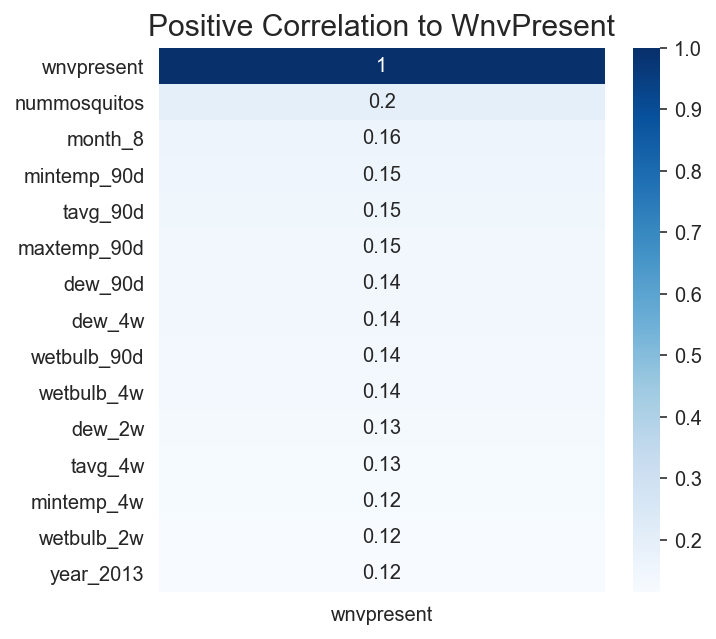

In [88]:
# plot features with positive corr to WNV
plt.figure(figsize = (5,5))
train_corr = train.corr()[['wnvpresent']].sort_values('wnvpresent', ascending=False)
positive_corr = train_corr.head(15)

sns.heatmap(positive_corr, annot = True, cmap='Blues')
plt.title('Positive Correlation to WnvPresent', fontsize=15);

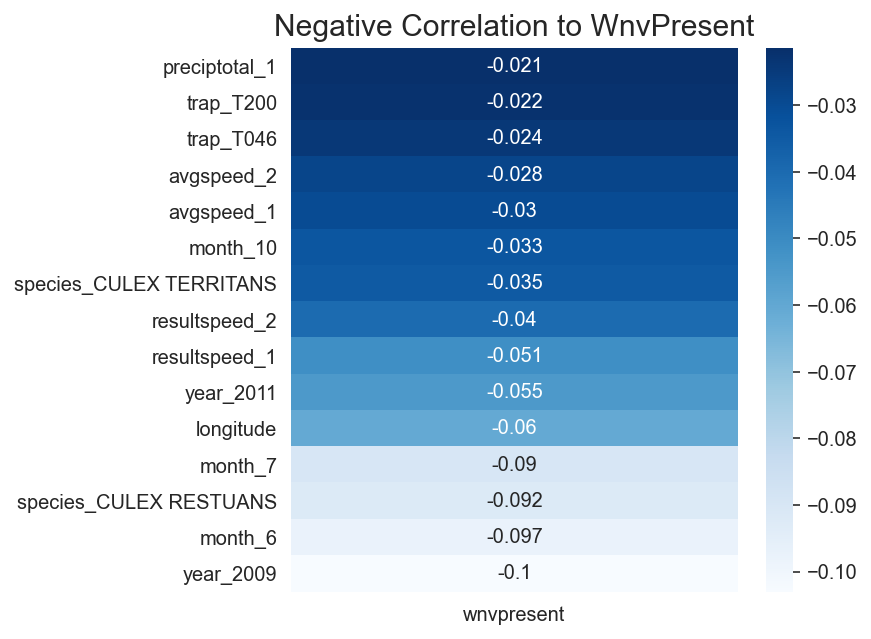

In [89]:
# plot features with negative corr to WNV
plt.figure(figsize = (5,5))
train_corr = train.corr()[['wnvpresent']].sort_values('wnvpresent', ascending=False)
negative_corr = train_corr.tail(15)

sns.heatmap(negative_corr, annot = True, cmap='Blues')
plt.title('Negative Correlation to WnvPresent', fontsize=15);

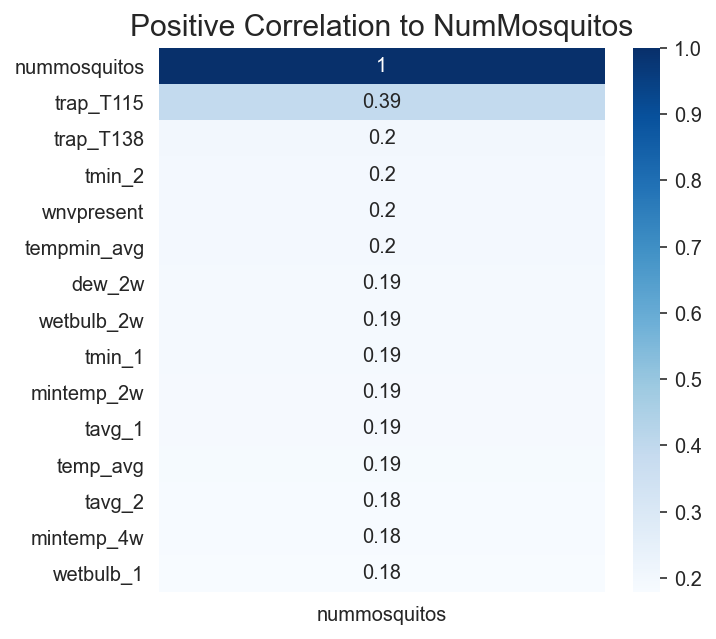

In [90]:
# plot features with positive corr to nos of mosquitoes present
plt.figure(figsize = (5,5))
train_corr = train.corr()[['nummosquitos']].sort_values('nummosquitos', ascending=False)
positive_corr = train_corr.head(15)

sns.heatmap(positive_corr, annot = True, cmap='Blues')
plt.title('Positive Correlation to NumMosquitos', fontsize=15);

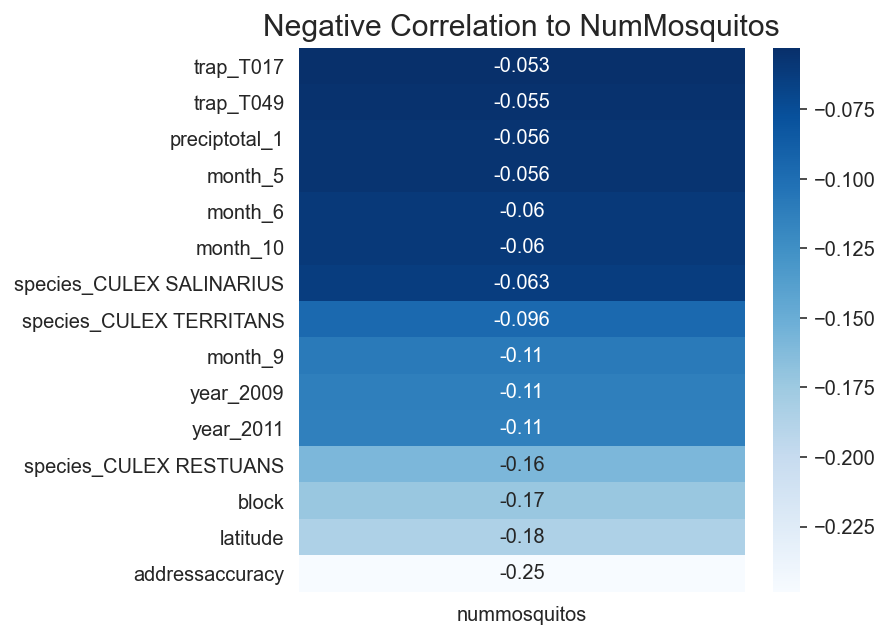

In [91]:
# plot features with positive corr to nos of mosquitoes present
plt.figure(figsize = (5,5))
train_corr = train.corr()[['nummosquitos']].sort_values('nummosquitos', ascending=False)
negative_corr = train_corr.tail(15)

sns.heatmap(negative_corr, annot = True, cmap='Blues')
plt.title('Negative Correlation to NumMosquitos', fontsize=15);

<div class="alert alert-block alert-info">

<b>Get dummy columns:</b>
- species
- trap
- year
- month

</div>

In [92]:
# Drop columns that is not in the test set 
train.drop(['nummosquitos'], axis=1, inplace=True)
train.shape

(10506, 214)

In [93]:
# # Drop address related columns 
# train.drop(['address','block','street','addressnumberstreet','address_accuracy'], axis=1, inplace=True)

In [94]:
# Save dataset
train.to_csv('../assets/final_train.csv')

***

# Prep Test set

In [95]:
# applying changes to test set via function
apply_change_df(test)

dataset shape: (116293, 227)


<div class="alert alert-block alert-info">

<b>Observation:</b>

- The number of columns in the train data does not tally with the column data. Hence further exploration is required.

</div>

In [96]:
#Get missing columns in the training test
missing_cols = set( train.columns ) - set( test.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
test = test[train.columns]

In [97]:
# view shape
test.shape

(116293, 214)

In [98]:
# saving into csv file
test.to_csv('../assets/final_test.csv', index=False)